IDEAT: KMEANS VIX, Cap max weight for factor

<div style="font-size:14px;">
<strong>TO DO:</strong><br><br>
Tarkistaa ovatko regiimit oikein, exp. antaa ainoana kaikille neg sharpet<br>
Katsoa vielä financial turbulence koodi<br>
Data varmistukset (ei dataa tulevaisuudesta)<br><br>

<strong>Lisää features:</strong><br>
RSI<br>
Yield spread<br>
Muita??<br><br>

<strong>Muuta:</strong><br>
regiimi testaus drawdowneilla?<br><br>
regiimi specifi model ennustus?


<strong>Mallin kehitys:</strong><br>
1. Feature eliminointi<br>
2. Training interval<br>
3. Hyperparametrit
</div>



##Model settings

In [33]:
use_regime_split = False

#Default models
RF = True # perus random forest
GB = False # perus gradient boost
Hybrid = False

#Looping models
RF_feature_seek = False # random forest all combinations
seek_all = False

#DATA
FF5 = True
FF5_long = False
MSCI = False

local = False #ajetaanko colab vai oma kone




In [34]:
if sum([RF, GB, RF_feature_seek, Hybrid, seek_all]) != 1:
    raise ValueError("Error: Exactly one of [RF, GB, RF_feature_seek, Hybrid, seek_all] must be True.")

# Check subgroup 2: Exactly one of [FF5, FF5_long, MSCI] must be True
if sum([FF5, FF5_long, MSCI]) != 1:
    raise ValueError("Error: Exactly one of [FF5, FF5_long, MSCI] must be True.")

print("Toggles are correctly set.")


Toggles are correctly set.


In [35]:
# # Import Required Libraries
#
# Import all necessary libraries for data manipulation, visualization,
# machine learning, and regression analysis.

# %%
import os
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from tabulate import tabulate

from IPython.display import display, HTML


In [36]:
if not local:

  %cd /content
  !rm -rf Gradu
  !git clone https://github.com/Elkkujou/Gradu.git
  %cd /content/Gradu
  !ls
  xls_file = pd.ExcelFile("/content/Gradu/THE_2ND_latest.xlsx")


else:



    repo_url = "https://github.com/Elkkujou/Gradu.git"
    repo_name = "Gradu"  # Name of the cloned folder

    # Check if the directory already exists
    if os.path.exists(repo_name):
        print(f"Folder '{repo_name}' already exists. Pulling latest changes...")
        # Change to the existing repo folder and pull the latest updates
        subprocess.run(["git", "-C", repo_name, "pull"], check=True)
    else:
        print(f"Cloning repository into '{repo_name}'...")
        subprocess.run(["git", "clone", repo_url], check=True)

    # List contents of the cloned repository
    subprocess.run(["ls", repo_name], check=True)
    xls_file = pd.ExcelFile("Gradu/THE_2ND_latest.xlsx")



/content
Cloning into 'Gradu'...
remote: Enumerating objects: 679, done.
remote: Counting objects: 100% (259/259), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 679 (delta 207), reused 124 (delta 124), pack-reused 420 (from 2)
Receiving objects: 100% (679/679), 125.40 MiB | 31.40 MiB/s, done.
Resolving deltas: 100% (331/331), done.
/content/Gradu
 chatti_RF.ipynb		      regime_prediction_msci.ipynb
 data+regimes.xlsx		      regime_pred.txt
 Fama_french_XGBOOST.ipynb	      RF_Gradu.ipynb
'Financial turbulence.ipynb'	     'RF REGIIMI HYVÄ TRAINING.ipynb'
 FT_source.xlsx			     'RF_REGIIMI_HYVÄ_TRAINING (MSCI).ipynb'
 Gradient_boost_malli.ipynb	     'RF_regime (3).ipynb'
 MSCI_XGBOOST.ipynb		      THE_2ND_latest.xlsx
 Regiimi_prediction.ipynb	      THE_2ND.xlsx
 regime_prediction_famafrench.ipynb   THE_ONE.xlsx


In [37]:
if FF5:
  SHEET_NAME = "ajodata_FF5"
  FEATURES = ['CPI%', 'GARCH_1M', 'LEI%', 'Amihud']
  FACTORS = [
    'SMB',
    'HML',
    'CMA',
    'RMW',
    #'RF'
]
  BENCHMARK = ['Mkt']
  show_benchmark = False

In [38]:
if FF5_long:
  SHEET_NAME = "ajodata_FF5_long"
  FEATURES = ['CPI%', 'GARCH_1M', 'T10YFF', 'LEI%', 'Amihud']
  FACTORS = [
    'SMB',
    'HML',
    'CMA',
    'RMW',
    #'RF'
]
  BENCHMARK = ['Mkt']
  show_benchmark = True

In [39]:
if MSCI:
  SHEET_NAME = "ajodata_MSCI"
  FEATURES = ['CPI%', 'GARCH_1M', 'T10YFF', 'LEI%', 'Amihud']
  FACTORS = [
    'Size',
    'value',
    'Quality',
    'min_vola']
  BENCHMARK = ['Us_standard']
  show_benchmark = True

##Prepare data

In [40]:
df = xls_file.parse(SHEET_NAME)
df.columns = df.columns.get_level_values(0)

# Print headers dynamically
print(f"Headers in the '{SHEET_NAME}' sheet:")
print(df.columns)

REGIMES_COLUMN = 'Predicted_reg'

# Convert the leftmost column (assumed to be the date column) to datetime
date_column = df.columns[0]
df[date_column] = pd.to_datetime(df[date_column])

# Retrieve first and last observation dates and count observations
first_date = df[date_column].iloc[0]
last_date = df[date_column].iloc[-1]
n_observations = len(df)

# Create a DataFrame with the information
info_df = pd.DataFrame({
    "Description": ["First observation date", "Last observation date", "Total number of observations"],
    "Value": [first_date, last_date, n_observations]
})

# Display the results as a neat HTML table
display(HTML(info_df.to_html(index=False, classes="table table-striped", border=0)))



Headers in the 'ajodata_FF5' sheet:
Index(['Date', 'SMB', 'HML', 'RMW', 'CMA', 'Mkt', 'RF', 'Mkt-RF', 'GARCH_1M',
       'CPI%', 'T10YFF', 'Amihud', 'LEI%', 'Cape', 'Cape %'],
      dtype='object')


Description,Value
First observation date,1963-07-30 00:00:00
Last observation date,2024-11-30 00:00:00
Total number of observations,737


In [41]:

# --- Define Helper Functions ---
def annualized_return(returns):
    """Compute the compounded annualized return (assuming monthly returns)."""
    return np.prod(1 + returns)**(12 / len(returns)) - 1

def compute_metrics(returns):
    """
    Compute key metrics for a returns series:
      - Annualized Return
      - Annualized Volatility (assuming monthly returns)
      - Total Cumulative Return
    """
    cumulative_returns = (1 + returns).cumprod()
    total_cum_return = cumulative_returns.iloc[-1] - 1
    ann_ret = annualized_return(returns)
    ann_vol = np.std(returns) * np.sqrt(12)
    return ann_ret, ann_vol, total_cum_return

# --- Compute Metrics for Benchmark and Each Factor ---
metrics = []

# Compute metrics for the benchmark.
benchmark_returns = df[BENCHMARK[0]]
bench_ann_ret, bench_ann_vol, bench_cum_return = compute_metrics(benchmark_returns)
metrics.append({
    "Strategy": "Benchmark",
    "Annualized Return": f"{bench_ann_ret*100:.2f}%",
    "Annualized Volatility": f"{bench_ann_vol*100:.2f}%",
    "Total Cumulative Return": f"{bench_cum_return*100:.2f}%"
})

# Compute metrics for each factor in FACTORS.
for factor in FACTORS:
    factor_returns = df[factor]
    factor_ann_ret, factor_ann_vol, factor_cum_return = compute_metrics(factor_returns)
    metrics.append({
        "Strategy": factor,
        "Annualized Return": f"{factor_ann_ret*100:.2f}%",
        "Annualized Volatility": f"{factor_ann_vol*100:.2f}%",
        "Total Cumulative Return": f"{factor_cum_return*100:.2f}%"
    })

# Create a DataFrame from the metrics.
metrics_df = pd.DataFrame(metrics)

# --- Display the Results as an HTML Table ---
display(HTML(metrics_df.to_html(index=False)))





Strategy,Annualized Return,Annualized Volatility,Total Cumulative Return
Benchmark,10.71%,15.46%,51691.71%
SMB,1.89%,10.55%,216.75%
HML,2.88%,10.37%,473.19%
CMA,2.88%,7.18%,472.94%
RMW,3.14%,7.67%,568.93%


In [42]:
# # Prepare Data for Model Training – Data Cleaning & Verification

# we keep all rows and compute the winning factor as the factor (from FACTORS) with the highest value in each row.

# Print the initial number of rows.
initial_rows = len(df)
print(f"Total number of rows before cleaning: {initial_rows}")

# Check missing values in feature columns (FEATURES) before dropping NAs.
missing_counts = df[FEATURES].isna().sum()
print("\nMissing values in feature columns before dropping NA:")
print(missing_counts)

# Save the number of rows before dropping NA and then drop rows with missing values in FEATURES.
initial_rows_features = len(df)
X = df[FEATURES].dropna()
rows_after_drop = len(X)
dropped_rows = initial_rows_features - rows_after_drop

if dropped_rows > 0:
    print(f"\nDropped {dropped_rows} rows due to missing values in feature columns.")
else:
    print("\nNo missing values found in feature columns. Data is clean.")

# Compute the Winning Factor by taking the column (from FACTORS) that has the maximum value in each row.
# This assumes that the FACTORS columns exist in df and contain numeric values.
df['Winning Factor'] = df[FACTORS].idxmax(axis=1)

# Define the target variable based on rows retained in X.
# The winning factor is encoded as a categorical variable.
y = df['Winning Factor'].astype('category').cat.codes.loc[X.index]
print("\nIndices aligned:", X.index.equals(y.index))

# Ensure the data is sorted by date.
df = df.sort_values('Date').reset_index(drop=True)

# Verify that all required columns exist.
# Here, we require the FEATURES columns, the 'USA Standard (Large+Mid Cap)' column,
# as well as all the FACTORS and the BENCHMARK columns.
required_columns = FEATURES + FACTORS + BENCHMARK
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")
print("\nParameters and dataset verified.")

# Compute the counts for each winning factor.
winning_factor_counts = df['Winning Factor'].value_counts()

# Compute total count and append it as the last row.
total_counts = winning_factor_counts.sum()
winning_factor_counts = pd.concat([winning_factor_counts, pd.Series({'Total': total_counts})])

# Print the counts with "Total" as the last row.
print("\nWinning Factor counts:")
print(winning_factor_counts)




Total number of rows before cleaning: 737

Missing values in feature columns before dropping NA:
CPI%        0
GARCH_1M    0
LEI%        0
Amihud      0
dtype: int64

No missing values found in feature columns. Data is clean.

Indices aligned: True

Parameters and dataset verified.

Winning Factor counts:
SMB      227
RMW      217
HML      175
CMA      118
Total    737
dtype: int64


In [43]:
if use_regime_split:

    # --- Regime Mapping & Conversion to Numeric Codes (Dynamic) ---

    # Dynamically extract the unique values in the REGIMES_COLUMN.
    unique_regimes = df[REGIMES_COLUMN].unique()

    # Convert the Regimes column to a categorical type with the unique values, ordered alphabetically.
    df[REGIMES_COLUMN] = pd.Categorical(df[REGIMES_COLUMN], categories=sorted(unique_regimes), ordered=True)

    # Create a dictionary mapping numeric codes to the regime names based on the unique values.
    regime_mapping = {i: cat for i, cat in enumerate(df[REGIMES_COLUMN].cat.categories)}

    # Now encode the Regimes column as numeric codes.
    df[REGIMES_COLUMN] = df[REGIMES_COLUMN].cat.codes

    # Create a mapping from numeric codes to original regime names.
    regime_short_mapping = {code: name for code, name in regime_mapping.items()}

    # Calculate the number of observations for each regime using value_counts (without reindexing).
    obs_counts = df[REGIMES_COLUMN].value_counts(sort=False)

    # Create a DataFrame preview of the regime mapping, including observation counts.
    mapping_table_data = []
    for code in regime_mapping.keys():
        mapping_table_data.append({
            "Numeric Code": code,
            "Original Name": regime_mapping.get(code, "N/A"),
            "Observations": obs_counts.get(code, 0)
        })

    # Append a row with the total observations.
    total_obs = obs_counts.sum()
    mapping_table_data.append({
        "Numeric Code": "",
        "Original Name": "Total",
        "Observations": total_obs
    })

    # Create the DataFrame for regime mapping preview and print.
    regime_mapping_df = pd.DataFrame(mapping_table_data)

    from tabulate import tabulate
    print("Preview of Dynamic Regime Mapping:")
    print(tabulate(regime_mapping_df, headers="keys", tablefmt="psql", showindex=False))


# Training

### Hyperparameters Table

| Hyperparameter       | Purpose                                   | Common Choices                  |
|----------------------|-------------------------------------------|---------------------------------|
| `n_estimators`      | Number of trees                           | 100 (default), 200, 500         |
| `max_depth`         | Max tree depth                            | `None` (default), 10, 20        |
| `min_samples_split` | Min samples needed to split a node       | 2 (default), 10, 20             |
| `min_samples_leaf`  | Min samples in a leaf                    | 1 (default), 5, 10              |
| `max_features`      | Features per split                       | `'sqrt'` (default), `'log2'`, `None` |
| `bootstrap`         | Use bootstrap sampling                    | `True` (default), `False`       |
| `random_state`      | Set a random seed                         | `None`, 42, 0                   |
| `criterion`         | Splitting method                          | `'gini'` (default), `'entropy'` |
| `oob_score`        | Out-of-bag validation                     | `False` (default), `True`       |
| `n_jobs`           | Parallel training                         | `None`, `-1` (all CPUs)         |


In [44]:
# This removes any row with at least one NaN in any column
df = df.dropna()

# Optionally, reindex the rows
df.reset_index(drop=True, inplace=True)

In [45]:
df

,Date,SMB,HML,RMW,CMA,Mkt,RF,Mkt-RF,GARCH_1M,CPI%,T10YFF,Amihud,LEI%,Cape,Cape %,Winning Factor
0,1963-08-30,-0.0080,0.0180,0.0036,-0.0035,0.0532,0.0025,0.0507,0.281066,0.19550,0.57,6.112556e-13,0.006803,1.106774,0.009239,HML
1,1963-09-30,-0.0052,0.0013,-0.0071,0.0029,-0.0130,0.0027,-0.0157,0.431188,-0.09756,0.65,8.801949e-13,0.003378,1.116794,0.009053,CMA
2,1963-10-30,-0.0139,-0.0010,0.0280,-0.0201,0.0282,0.0029,0.0253,0.444504,0.09766,0.58,6.240603e-12,0.010101,1.122111,0.004761,RMW
3,1963-11-30,-0.0088,0.0175,-0.0051,0.0224,-0.0058,0.0027,-0.0085,1.526543,0.09756,0.89,5.778983e-12,0.006667,1.130949,0.007877,CMA
4,1963-12-30,-0.0210,-0.0002,0.0003,-0.0007,0.0212,0.0029,0.0183,0.316026,0.32489,0.65,4.193943e-12,0.006623,1.136019,0.004482,RMW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,2024-07-30,0.0828,0.0574,0.0022,0.0043,0.0169,0.0045,0.0124,1.087011,0.13892,-1.42,0.000000e+00,-0.001940,1.257904,0.004980,SMB
732,2024-08-30,-0.0365,-0.0113,0.0085,0.0086,0.0209,0.0048,0.0161,0.641443,0.18019,-1.02,0.000000e+00,-0.004859,1.264477,0.005225,CMA
733,2024-09-30,-0.0102,-0.0259,0.0004,-0.0026,0.0214,0.0040,0.0174,0.396629,0.22920,-0.55,0.000000e+00,-0.002930,1.269959,0.004335,RMW
734,2024-10-30,-0.0088,0.0089,-0.0138,0.0103,-0.0058,0.0039,-0.0097,0.684819,0.22646,-0.40,0.000000e+00,-0.003918,1.271925,0.001548,CMA


##Feature seek

In [46]:
if RF_feature_seek:
    import itertools
    import os
    import time
    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier

    # --------------------------
    # Parameters for Feature & Training Window Search
    # --------------------------
    min_features = 2                  # minimum number of features in a subset
    max_features = len(FEATURES)      # maximum number of features (or set to a smaller number if desired)

    # Define fixed rolling window sizes (in years) to test (assuming monthly data)
    training_window_years = [5, 10, 15, 20]

    # Also run an expanding window experiment
    run_expanding_window = True

    # Independent variable: minimum number of observations required for making a prediction.
    # This is now decoupled from the training window calculation.
    min_obs_for_prediction = 60  # adjust this value as desired

    output_filename = "feature_subset_results.csv"
    if os.path.exists(output_filename):
        os.remove(output_filename)

    # Ensure the data is sorted by date.
    df_sorted = df.sort_values('Date').reset_index(drop=True)

    # --------------------------
    # Outer Loop: Fixed Rolling Window Modes
    # --------------------------
    for years in training_window_years:
        # Convert years to number of observations (assume 12 obs per year)
        rolling_window_size = years * 12
        # Ensure predictions start only after both the rolling window and the independent minimum are met.
        start_index = max(min_obs_for_prediction, rolling_window_size)
        print(f"\n--- Testing fixed rolling window of {years} years "
              f"({rolling_window_size} observations, starting predictions at index {start_index}) ---")
        outer_start_time = time.time()

        # Inner loop over feature subset sizes
        for r in range(min_features, max_features + 1):
            # Loop over all combinations of size r
            for comb in itertools.combinations(FEATURES, r):
                current_features = list(comb)
                inner_start_time = time.time()
                print(f"\nTesting feature combination: {current_features}")
                results = []

                # Loop over test rows, starting when we have enough training data
                for i in range(start_index, len(df_sorted)):
                    test_row = df_sorted.iloc[i]
                    Predicted_month = test_row['Date']

                    # Build fixed rolling training window (most recent rolling_window_size observations)
                    train_window = df_sorted.iloc[i - rolling_window_size : i].copy()

                    # Ensure the last training observation is strictly before test row date
                    last_train_date = train_window['Date'].iloc[-1]
                    if (last_train_date.year == Predicted_month.year) and \
                       (last_train_date.month >= Predicted_month.month):
                        continue

                    # (Optional) Regime check if use_regime_split is True:
                    if use_regime_split:
                        regime_counts = train_window[REGIMES_COLUMN].value_counts()
                        insufficient_regimes = regime_counts[regime_counts < min_obs_regime].index.tolist()
                        if insufficient_regimes:
                            continue
                        current_regime = test_row[REGIMES_COLUMN]
                        train_window = train_window[train_window[REGIMES_COLUMN] == current_regime]
                        if len(train_window) < min_obs_regime:
                            continue

                    # Prepare training data for the current feature subset.
                    X_train = train_window[list(current_features)].dropna()
                    y_train = train_window['Winning Factor'].loc[X_train.index]
                    if len(X_train) < 1:
                        continue

                    # Train the RandomForest model.
                    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                    rf_model.fit(X_train, y_train)

                    # Use the last row of the training window as test data.
                    X_test = train_window[list(current_features)].iloc[[-1]].dropna()
                    if X_test.empty:
                        continue

                    predicted_probabilities = rf_model.predict_proba(X_test)[0]
                    predicted_winner = rf_model.classes_[predicted_probabilities.argmax()]

                    # Map the predicted probabilities to the full set of FACTORS.
                    full_probs = np.zeros(len(FACTORS))
                    for cls, prob in zip(rf_model.classes_, predicted_probabilities):
                        try:
                            idx = FACTORS.index(cls)
                            full_probs[idx] = prob
                        except ValueError:
                            continue

                    allocated_return = (full_probs * test_row[FACTORS].values).sum()

                    # months_ahead: how many months ahead the prediction is (optional usage)
                    months_ahead = (
                        (Predicted_month.year - last_train_date.year) * 12 +
                        (Predicted_month.month - last_train_date.month)
                    )

                    # Collect feature levels for logging
                    feature_levels = {
                        f"Feature_Level_{f}": X_test[f].iloc[0] for f in current_features
                    }

                    # Create a result row
                    result = {
                        "TrainingWindowYears": years,   # <--- Record the training window
                        "Features_used": str(current_features),
                        "Predicted_month": Predicted_month,
                        "Allocated_Return": allocated_return,
                        "Predicted_Winner": predicted_winner,
                        "Actual_Winner": test_row['Winning Factor'],
                        "Prediction_Horizon_Months": months_ahead,
                        **feature_levels
                    }
                    results.append(result)

                # End of inner test row loop for this feature combination.
                if results:
                    df_results_comb = pd.DataFrame(results)
                    if not os.path.exists(output_filename):
                        df_results_comb.to_csv(output_filename, mode='a', header=True, index=False)
                    else:
                        df_results_comb.to_csv(output_filename, mode='a', header=False, index=False)
                    elapsed_inner = time.time() - inner_start_time
                    minutes = int(elapsed_inner // 60)
                    seconds = int(elapsed_inner % 60)
                    print(f"Results for combination {current_features} appended to CSV. "
                          f"Time taken: {minutes:02d}:{seconds:02d}")

        elapsed_outer = time.time() - outer_start_time
        minutes = int(elapsed_outer // 60)
        seconds = int(elapsed_outer % 60)
        print(f"Completed fixed rolling window of {years} years in {minutes:02d}:{seconds:02d}")

    # --------------------------
    # Expanding Window Mode
    # --------------------------
    if run_expanding_window:
        print("\n--- Testing Expanding Window Mode ---")
        outer_start_time = time.time()
        for r in range(min_features, max_features + 1):
            for comb in itertools.combinations(FEATURES, r):
                current_features = list(comb)
                inner_start_time = time.time()
                print(f"\nTesting feature combination (expanding): {current_features}")
                results = []

                # In expanding mode, the training window goes from the start until the test row.
                # Start predictions only after the minimum observation threshold is met.
                for i in range(min_obs_for_prediction, len(df_sorted)):
                    test_row = df_sorted.iloc[i]
                    Predicted_month = test_row['Date']
                    train_window = df_sorted.iloc[:i].copy()
                    if train_window.empty:
                        continue

                    last_train_date = train_window['Date'].iloc[-1]
                    if (last_train_date.year == Predicted_month.year) and \
                       (last_train_date.month >= Predicted_month.month):
                        continue

                    X_train = train_window[list(current_features)].dropna()
                    y_train = train_window['Winning Factor'].loc[X_train.index]
                    if len(X_train) < 1:
                        continue

                    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                    rf_model.fit(X_train, y_train)

                    X_test = train_window[list(current_features)].iloc[[-1]].dropna()
                    if X_test.empty:
                        continue

                    predicted_probabilities = rf_model.predict_proba(X_test)[0]
                    predicted_winner = rf_model.classes_[predicted_probabilities.argmax()]

                    full_probs = np.zeros(len(FACTORS))
                    for cls, prob in zip(rf_model.classes_, predicted_probabilities):
                        try:
                            idx = FACTORS.index(cls)
                            full_probs[idx] = prob
                        except ValueError:
                            continue

                    allocated_return = (full_probs * test_row[FACTORS].values).sum()

                    months_ahead = (
                        (Predicted_month.year - last_train_date.year) * 12 +
                        (Predicted_month.month - last_train_date.month)
                    )

                    feature_levels = {
                        f"Feature_Level_{f}": X_test[f].iloc[0] for f in current_features
                    }

                    result = {
                        "TrainingWindowYears": "expanding",  # <--- Indicate expanding window
                        "Features_used": str(current_features),
                        "Predicted_month": Predicted_month,
                        "Allocated_Return": allocated_return,
                        "Predicted_Winner": predicted_winner,
                        "Actual_Winner": test_row['Winning Factor'],
                        "Prediction_Horizon_Months": months_ahead,
                        **feature_levels
                    }
                    results.append(result)

                if results:
                    df_results_comb = pd.DataFrame(results)
                    if not os.path.exists(output_filename):
                        df_results_comb.to_csv(output_filename, mode='a', header=True, index=False)
                    else:
                        df_results_comb.to_csv(output_filename, mode='a', header=False, index=False)
                    elapsed_inner = time.time() - inner_start_time
                    minutes = int(elapsed_inner // 60)
                    seconds = int(elapsed_inner % 60)
                    print(f"Expanding window: Results for combination {current_features} "
                          f"appended to CSV. Time taken: {minutes:02d}:{seconds:02d}")

        elapsed_outer = time.time() - outer_start_time
        minutes = int(elapsed_outer // 60)
        seconds = int(elapsed_outer % 60)
        print(f"Completed Expanding Window Mode in {minutes:02d}:{seconds:02d}")


##Seek all

In [47]:
if seek_all:
    import pandas as pd
    import numpy as np
    import time
    from itertools import product, combinations
    from sklearn.ensemble import RandomForestClassifier
    from datetime import datetime

    # =============================================================================
    # 0) Setup: Global Variables & Parameters
    # =============================================================================
    # Assumptions:
    # - df, FEATURES, and FACTORS are defined before this block.
    # - If using regime split, define REGIMES_COLUMN and regime_short_mapping.
    use_regime_split = False
    min_months_train = 60    # Minimum training months required
    min_obs_regime = 50      # Minimum observations per regime (if regime split is used)
    min_obs_train = 0        # Minimum observations in training data after NA-drop
    use_fixed_window = True  # True for a fixed (rolling) window; False for an expanding window

    # Feature combination settings
    min_features = len(FEATURES)                   # Minimum number of features to test
    max_features = len(FEATURES)       # Maximum number of features (using all candidate features)

    # Training window sizes to try (in months)
    training_windows_list = [60, 120]

    # Hyperparameter grid for grid search (default configuration)
    hyperparameter_grid = {
        "n_estimators": [100],
        "max_depth": [None],
        "max_features": ['sqrt'],  # Note: the extra None in the original dict is removed
        "min_samples_split": [2],
        "min_samples_leaf": [1],
        "bootstrap": [True, False]
    }

    # =============================================================================
    # 1) Precompute combinations and setup logs
    # =============================================================================
    hyperparameter_combinations = [
        dict(zip(hyperparameter_grid.keys(), values))
        for values in product(*hyperparameter_grid.values())
    ]

    feature_combinations = [
        list(combo)
        for r in range(min_features, max_features + 1)
        for combo in combinations(FEATURES, r)
    ]

    total_iterations = len(training_windows_list) * len(feature_combinations) * len(hyperparameter_combinations)
    print(f"Total iterations to run: {total_iterations}")

    log_entries = []           # To log results for CSV
    iteration_results_log = [] # For ranking across iterations
    iteration_number = 0

    df_sorted = df.sort_values('Date').reset_index(drop=True)

    # =============================================================================
    # 2) Main 3-Layer Loop
    # =============================================================================
    for train_window_size in training_windows_list:
        for current_features in feature_combinations:
            for rf_params in hyperparameter_combinations:
                iteration_number += 1
                iter_start_time = time.time()
                results = []

                for i in range(1, len(df_sorted)):
                    test_row = df_sorted.iloc[i]
                    Predicted_month = test_row['Date']

                    # Build training window
                    if use_fixed_window:
                        start_idx = max(0, i - train_window_size)
                        train_window = df_sorted.iloc[start_idx:i].copy()
                    else:
                        train_window = df_sorted.iloc[:i].copy()

                    # Ensure sufficient training data exists
                    if len(train_window) < min_months_train:
                        continue

                    train_start_date = train_window['Date'].iloc[0]
                    train_end_date = train_window['Date'].iloc[-1]

                    # Regime split (if applicable)
                    if use_regime_split:
                        regime_counts = train_window[REGIMES_COLUMN].value_counts()
                        if any(regime_counts < min_obs_regime):
                            continue
                        current_regime = test_row[REGIMES_COLUMN]
                        train_window = train_window[train_window[REGIMES_COLUMN] == current_regime]
                        if len(train_window) < min_obs_regime:
                            continue
                        regime_used = regime_short_mapping.get(current_regime, str(current_regime))
                    else:
                        regime_used = 'NoRegime'

                    # Ensure last training date is strictly before the test date
                    last_train_date = train_window['Date'].iloc[-1]
                    if (last_train_date.year == Predicted_month.year) and (last_train_date.month >= Predicted_month.month):
                        continue

                    # Prepare training data using the current feature subset
                    X_train = train_window[current_features].dropna()
                    y_train = train_window['Winning Factor'].loc[X_train.index]
                    if len(X_train) < min_obs_train:
                        continue

                    try:
                        rf_model = RandomForestClassifier(**rf_params, random_state=42)
                        rf_model.fit(X_train, y_train)
                    except Exception as e:
                        # Skip iteration if model fitting fails
                        continue

                    # Use the last row in training window for testing
                    X_test = train_window[current_features].iloc[[-1]].dropna()
                    if X_test.empty:
                        continue

                    try:
                        predicted_probabilities = rf_model.predict_proba(X_test)[0]
                    except Exception as e:
                        continue

                    # Map predicted probabilities onto full FACTORS vector
                    full_probs = np.zeros(len(FACTORS))
                    for cls, prob in zip(rf_model.classes_, predicted_probabilities):
                        try:
                            idx = FACTORS.index(cls)
                            full_probs[idx] = prob
                        except ValueError:
                            continue

                    allocated_return = (full_probs * test_row[FACTORS].values).sum()
                    equal_weight_return = np.mean(test_row[FACTORS].values)

                    results.append({
                        'Predicted_month': Predicted_month,
                        'Allocated_Return': allocated_return,
                        'Equal_Weight_Return': equal_weight_return,
                        'Train_Start_Date': train_start_date,
                        'Train_End_Date': train_end_date
                    })

                # =============================================================================
                # 3) End-of-Iteration Calculations & Metrics
                # =============================================================================
                results_df = pd.DataFrame(results)
                if results_df.empty:
                    cum_return_allocated = np.nan
                    cum_return_equal = np.nan
                    cum_return_allocated_total = np.nan
                    cum_return_equal_total = np.nan
                    first_pred_date = None
                    last_pred_date = None
                    winning_months_str = None
                    sharpe_ratio = np.nan
                    win_months = np.nan
                    total_months = np.nan
                else:
                    # Filter for predictions from January 1, 2000 onward
                    filtered = results_df[results_df['Predicted_month'] >= pd.Timestamp("2000-01-01")]
                    if not filtered.empty:
                        cum_return_allocated = (1 + filtered['Allocated_Return']).prod() - 1
                        cum_return_equal = (1 + filtered['Equal_Weight_Return']).prod() - 1
                        first_pred_date = filtered.iloc[0]['Predicted_month']
                        last_pred_date = filtered.iloc[-1]['Predicted_month']
                        win_months = (filtered['Allocated_Return'] > filtered['Equal_Weight_Return']).sum()
                        total_months = len(filtered)
                        winning_months_str = f"{win_months}/{total_months}"
                        # Calculate Sharpe Ratio (assume zero risk-free rate)
                        std_alloc = filtered['Allocated_Return'].std()
                        sharpe_ratio = filtered['Allocated_Return'].mean() / std_alloc if std_alloc != 0 else np.nan
                    else:
                        cum_return_allocated = np.nan
                        cum_return_equal = np.nan
                        first_pred_date = None
                        last_pred_date = None
                        winning_months_str = None
                        sharpe_ratio = np.nan
                        win_months = np.nan
                        total_months = np.nan

                    cum_return_allocated_total = (1 + results_df['Allocated_Return']).prod() - 1
                    cum_return_equal_total = (1 + results_df['Equal_Weight_Return']).prod() - 1

                iter_time = time.time() - iter_start_time
                time_str = f"{int(iter_time // 60):02d}:{int(iter_time % 60):02d}"

                # Save iteration results for ranking (including Sharpe ratio and win months)
                iteration_results_log.append({
                    'Iteration': iteration_number,
                    'Cum_Return_Total': cum_return_allocated_total,
                    'Cum_Return_Post2000': cum_return_allocated,
                    'Sharpe_Ratio_Post2000': sharpe_ratio,
                    'Win_Months_Count': win_months  # Using absolute win count for ranking
                })

                # Compute ranking for total cumulative returns, post-2000 cumulative returns, Sharpe ratio, and win months count
                valid_total = [x['Cum_Return_Total'] for x in iteration_results_log if pd.notna(x['Cum_Return_Total'])]
                valid_post2000 = [x['Cum_Return_Post2000'] for x in iteration_results_log if pd.notna(x['Cum_Return_Post2000'])]
                valid_sharpe = [x['Sharpe_Ratio_Post2000'] for x in iteration_results_log if pd.notna(x['Sharpe_Ratio_Post2000'])]
                valid_win = [x['Win_Months_Count'] for x in iteration_results_log if pd.notna(x.get('Win_Months_Count'))]

                total_rank = sorted(valid_total, reverse=True).index(cum_return_allocated_total) + 1 if pd.notna(cum_return_allocated_total) else None
                post2000_rank = sorted(valid_post2000, reverse=True).index(cum_return_allocated) + 1 if pd.notna(cum_return_allocated) else None
                sharpe_rank = sorted(valid_sharpe, reverse=True).index(sharpe_ratio) + 1 if pd.notna(sharpe_ratio) else None
                win_months_rank = sorted(valid_win, reverse=True).index(win_months) + 1 if pd.notna(win_months) else None

                # Log this iteration's results (including equal weight, Sharpe ratio, and winning months rank)
                log_entry = {
                    'Iteration': iteration_number,
                    'Training_Window': train_window_size,
                    'Features': ','.join(current_features),
                    'Hyperparameters': ','.join(f"{k}={v}" for k, v in rf_params.items()),
                    'First_Prediction_Date': first_pred_date,
                    'Last_Prediction_Date': last_pred_date,
                    'Cumulative_Return_Post2000': cum_return_allocated,
                    'Cumulative_Return_Total': cum_return_allocated_total,
                    'Cumulative_Return_Equal_Post2000': cum_return_equal,
                    'Cumulative_Return_Equal_Total': cum_return_equal_total,
                    'Winning_Months': winning_months_str,
                    'Winning_Months_Rank': win_months_rank,
                    'Sharpe_Ratio_Post2000': sharpe_ratio
                }
                log_entries.append(log_entry)

                # Print iteration progress and metrics
                print(f"Iteration {iteration_number}/{total_iterations} | Duration: {time_str}")
                print(f"Total Cum Return (Allocated): {cum_return_allocated_total:.4f} | Post-2000: {cum_return_allocated:.4f}")
                print(f"Total Cum Return (Equal): {cum_return_equal_total:.4f} | Post-2000: {cum_return_equal:.4f}")
                print(f"Winning Months (Allocated > Equal): {winning_months_str} | Winning Months Rank: {win_months_rank}")
                print(f"Sharpe Ratio (Post-2000): {sharpe_ratio:.4f} | Sharpe Rank: {sharpe_rank}")
                print(f"Rank (Total): {total_rank} | Rank (Post-2000): {post2000_rank}\n")

    # =============================================================================
    # 3) Final Logging: Write all results to a timestamped CSV file
    # =============================================================================
    log_df = pd.DataFrame(log_entries)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"seek_all_results({timestamp}).csv"
    log_df.to_csv(filename, sep=";", index=False)
    print(f"Logged all results to '{filename}'.")

## Random forest

In [48]:
if RF or Hybrid:
    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier
    from IPython.display import display, HTML

    # -------------------
    # 1) Parameters
    # -------------------
    min_months_train = 60     # Minimum months of data needed (5 years for monthly data)
    min_obs_regime = 50       # Min obs per regime if splitting
    min_obs_train = 0         # Min total obs after dropping NAs
    use_regime_split = False  # Toggle regime-based training or not
    default_hyperparameters = False  # If True, override manually set hyperparameters

    # New toggle for training window type:
    use_fixed_window = True   # True for fixed (rolling) window, False for expanding window
    rolling_window_size = 120  # When using a fixed window, use this many most recent rows

    # -------------------
    # Hyperparameter Settings for Random Forest
    # -------------------
    if default_hyperparameters:
      #DEFAULTS!!!!
        rf_params = {
            'n_estimators': 100,      # Number of trees in the forest
            'max_depth': None,        # Maximum depth of each tree (None = no limit)
            'max_features': 'sqrt',   # Number of features to consider when looking for the best split
            'min_samples_split': 2,   # Minimum number of samples required to split an internal node
            'min_samples_leaf': 1,    # Minimum number of samples required to be at a leaf node
            'bootstrap': True         # Whether bootstrap samples are used when building trees
        }
    else:
        rf_params = {
            'n_estimators': 100,      # Number of trees in the forest
            'max_depth': None,        # Maximum depth of each tree (None = no limit)
            'max_features': 'sqrt',   # Number of features to consider when looking for the best split
            'min_samples_split': 2,   # Minimum number of samples required to split an internal node
            'min_samples_leaf': 1,    # Minimum number of samples required to be at a leaf node
            'bootstrap': False         # Whether bootstrap samples are used when building trees
        }

    df_sorted = df.sort_values('Date').reset_index(drop=True)
    results = []

    # -------------------
    # 2) Main Loop: Predict for each row in df_sorted
    # -------------------
    for i in range(1, len(df_sorted)):
        test_row = df_sorted.iloc[i]
        Predicted_month = test_row['Date']

        # Build training window: either a fixed-size (rolling) window or an expanding window
        if use_fixed_window:
            start_idx = max(0, i - rolling_window_size)
            train_window = df_sorted.iloc[start_idx:i].copy()
        else:
            train_window = df_sorted.iloc[:i].copy()

        # Check that we have enough training rows (i.e., months)
        if len(train_window) < min_months_train:
            print(f"Test row date: {Predicted_month.date()} - Insufficient training rows ({len(train_window)} rows). Skipping.")
            continue

        # Get first and last date in training window
        train_start_date = train_window['Date'].iloc[0]
        train_end_date = train_window['Date'].iloc[-1]

        # Regime-based checks
        if use_regime_split:
            regime_counts = train_window[REGIMES_COLUMN].value_counts()
            insufficient_regimes = regime_counts[regime_counts < min_obs_regime].index.tolist()
            if insufficient_regimes:
                regime_str_list = [regime_short_mapping.get(r, str(r)) for r in insufficient_regimes]
                regime_str = ", ".join(regime_str_list)
                print(f"Test row date: {Predicted_month.date()}")
                print(f"  🔴 Regime split active. Insufficient data in: {regime_str}. Skipping.\n")
                continue

            current_regime = test_row[REGIMES_COLUMN]
            train_window = train_window[train_window[REGIMES_COLUMN] == current_regime]
            if len(train_window) < min_obs_regime:
                regime_str = regime_short_mapping.get(current_regime, str(current_regime))
                print(f"Test row date: {Predicted_month.date()}")
                print(f"  🔴 Regime split active ({regime_str}). Only {len(train_window)} obs. Skipping.\n")
                continue
            regime_used = regime_short_mapping.get(current_regime, str(current_regime))
        else:
            regime_used = 'NoRegime'

        # Check that the last training date is strictly before the test date
        last_train_date = train_window['Date'].iloc[-1]
        if (last_train_date.year == Predicted_month.year) and (last_train_date.month >= Predicted_month.month):
            print(f"Test row {Predicted_month.date()}: last training date not strictly before test month. Skipping.\n")
            continue

        # Prepare X_train / y_train
        X_train = train_window[FEATURES].dropna()
        y_train = train_window['Winning Factor'].loc[X_train.index]
        if len(X_train) < min_obs_train:
            print(f"   -> After dropping NAs: {len(X_train)} < {min_obs_train}. Skipping.\n")
            continue

        # Fit RandomForest using the hyperparameter settings
        rf_model = RandomForestClassifier(**rf_params, random_state=42)
        rf_model.fit(X_train, y_train)

        # Predict using the last row in training window (previous month’s features)
        X_test = train_window[FEATURES].iloc[[-1]].dropna()
        if X_test.empty:
            print("   -> Test features empty, skipping iteration.\n")
            continue

        predicted_probabilities = rf_model.predict_proba(X_test)[0]
        predicted_winner = rf_model.classes_[predicted_probabilities.argmax()]

        # Map probabilities onto the full set of FACTORS
        full_probs = np.zeros(len(FACTORS))
        for cls, prob in zip(rf_model.classes_, predicted_probabilities):
            try:
                idx = FACTORS.index(cls)
                full_probs[idx] = prob
            except ValueError:
                pass

        # Calculate the strategy returns:
        allocated_return = (full_probs * test_row[FACTORS].values).sum()
        equal_weight_return = np.mean(test_row[FACTORS].values)

        # Gather additional info
        tree_depths = [estimator.tree_.max_depth for estimator in rf_model.estimators_]
        avg_depth = np.mean(tree_depths)
        max_depth_val = np.max(tree_depths)
        months_ahead = ((Predicted_month.year - last_train_date.year) * 12 +
                        (Predicted_month.month - last_train_date.month))
        feature_levels = {f"Feature_Level_{f}": X_test[f].iloc[0] for f in FEATURES}

        print(f"Test row date: {Predicted_month.date()} -> Model trained, prediction made (using: {train_start_date.date()} - {train_end_date.date()})")

        result = {
            'Regime': regime_used,
            'Predicted_month': Predicted_month,
            'Train_Start_Date': train_start_date,
            'Train_End_Date': train_end_date,
            'Train_Count': len(X_train),
            'Feature_Importances': rf_model.feature_importances_,
            'Predicted_Probabilities': full_probs,
            'Predicted_Winner': predicted_winner,
            'Allocated_Return': allocated_return,
            'Equal_Weight_Return': equal_weight_return,
            'Actual_Winner': test_row['Winning Factor'],
            'Num_Trees': rf_model.n_estimators,
            'Average_Tree_Depth': avg_depth,
            'Max_Tree_Depth': max_depth_val,
            'Prediction_Horizon_Months': months_ahead,
            **feature_levels
        }
        results.append(result)

    # -------------------
    # 3) Build the final results DataFrame for RF
    # -------------------
    results_df_rf = pd.DataFrame(results)
    print("Final results_df_rf columns:", results_df_rf.columns.tolist())
    display(results_df_rf.tail(10))

    # -------------------
    # 4) Calculate and Print Cumulative Returns (Filtered: from 1 Jan 2000 onwards)
    # -------------------
    filtered_results = results_df_rf[results_df_rf['Predicted_month'] >= pd.Timestamp("2000-01-01")]
    if not filtered_results.empty:
        cum_return_allocated = (1 + filtered_results['Allocated_Return']).prod() - 1
        cum_return_equal = (1 + filtered_results['Equal_Weight_Return']).prod() - 1

        first_pred_month = filtered_results.iloc[0]['Predicted_month']
        last_pred_month = filtered_results.iloc[-1]['Predicted_month']

        print("\nCumulative returns {} - {} - ML strategy: {:.4f} / Equal weight: {:.4f}".format(
            first_pred_month.date(), last_pred_month.date(),
            cum_return_allocated, cum_return_equal))
    else:
        print("No predictions from 1 Jan 2000 onwards.")

    # -------------------
    # 5) Calculate and Print Cumulative Returns for Total Time
    # -------------------
    if not results_df_rf.empty:
        cum_return_allocated_total = (1 + results_df_rf['Allocated_Return']).prod() - 1
        cum_return_equal_total = (1 + results_df_rf['Equal_Weight_Return']).prod() - 1

        first_total_month = results_df_rf.iloc[0]['Predicted_month']
        last_total_month = results_df_rf.iloc[-1]['Predicted_month']

        print("\nCumulative returns {} - {} - ML strategy: {:.4f} / Equal weight: {:.4f}".format(
            first_total_month.date(), last_total_month.date(),
            cum_return_allocated_total, cum_return_equal_total))
    else:
        print("No predictions available for total time.")


Test row date: 1963-09-30 - Insufficient training rows (1 rows). Skipping.
Test row date: 1963-10-30 - Insufficient training rows (2 rows). Skipping.
Test row date: 1963-11-30 - Insufficient training rows (3 rows). Skipping.
Test row date: 1963-12-30 - Insufficient training rows (4 rows). Skipping.
Test row date: 1964-01-30 - Insufficient training rows (5 rows). Skipping.
Test row date: 1964-02-29 - Insufficient training rows (6 rows). Skipping.
Test row date: 1964-03-30 - Insufficient training rows (7 rows). Skipping.
Test row date: 1964-04-30 - Insufficient training rows (8 rows). Skipping.
Test row date: 1964-05-30 - Insufficient training rows (9 rows). Skipping.
Test row date: 1964-06-30 - Insufficient training rows (10 rows). Skipping.
Test row date: 1964-07-30 - Insufficient training rows (11 rows). Skipping.
Test row date: 1964-08-30 - Insufficient training rows (12 rows). Skipping.
Test row date: 1964-09-30 - Insufficient training rows (13 rows). Skipping.
Test row date: 1964-1

,Regime,Predicted_month,Train_Start_Date,Train_End_Date,Train_Count,Feature_Importances,Predicted_Probabilities,Predicted_Winner,Allocated_Return,Equal_Weight_Return,Actual_Winner,Num_Trees,Average_Tree_Depth,Max_Tree_Depth,Prediction_Horizon_Months,Feature_Level_CPI%,Feature_Level_GARCH_1M,Feature_Level_LEI%,Feature_Level_Amihud
666,NoRegime,2024-02-29,2014-02-28,2024-01-30,120,"[0.25825857722454554, 0.2874451715145042, 0.26...","[0.0, 0.0, 0.0, 1.0]",RMW,-0.0198,-0.021050,SMB,100,13.28,18,1,0.34301,0.726558,-0.000954,0.0
667,NoRegime,2024-03-30,2014-03-30,2024-02-29,120,"[0.2537235914342506, 0.27984681644131815, 0.28...","[1.0, 0.0, 0.0, 0.0]",SMB,-0.0118,0.014250,HML,100,12.75,16,1,0.39639,0.780011,-0.004776,0.0
668,NoRegime,2024-04-30,2014-04-30,2024-03-30,120,"[0.2712789615410205, 0.2833425761975481, 0.282...","[0.0, 1.0, 0.0, 0.0]",HML,-0.0052,-0.004725,RMW,100,12.40,17,1,0.34885,0.496170,0.000960,0.0
669,NoRegime,2024-05-30,2014-05-30,2024-04-30,120,"[0.267779150783525, 0.2743360522713843, 0.2816...","[0.0, 0.0, 0.0, 1.0]",RMW,0.0297,-0.002500,RMW,100,12.63,18,1,0.29125,0.944764,-0.001918,0.0
670,NoRegime,2024-06-30,2014-06-30,2024-05-30,120,"[0.2700210873583201, 0.2844198374161658, 0.261...","[0.0, 0.0, 0.0, 1.0]",RMW,0.0051,-0.022375,RMW,100,12.30,17,1,0.03961,0.569002,-0.005764,0.0
671,NoRegime,2024-07-30,2014-07-30,2024-06-30,120,"[0.2665916715539848, 0.2876358121657694, 0.263...","[0.0, 0.0, 0.0, 1.0]",RMW,0.0022,0.036675,SMB,100,12.16,16,1,-0.00287,0.327046,-0.003865,0.0
672,NoRegime,2024-08-30,2014-08-30,2024-07-30,120,"[0.28049003307470055, 0.2894140827598423, 0.25...","[1.0, 0.0, 0.0, 0.0]",SMB,-0.0365,-0.007675,CMA,100,12.24,16,1,0.13892,1.087011,-0.001940,0.0
673,NoRegime,2024-09-30,2014-09-30,2024-08-30,120,"[0.27179121360719827, 0.2839010986023017, 0.26...","[0.0, 0.0, 1.0, 0.0]",CMA,-0.0026,-0.009575,RMW,100,12.09,17,1,0.18019,0.641443,-0.004859,0.0
674,NoRegime,2024-10-30,2014-10-30,2024-09-30,120,"[0.2783592147199605, 0.2743895376788022, 0.262...","[0.0, 0.0, 0.0, 1.0]",RMW,-0.0138,-0.000850,CMA,100,12.36,16,1,0.22920,0.396629,-0.002930,0.0
675,NoRegime,2024-11-30,2014-11-30,2024-10-30,120,"[0.27136433186990905, 0.27734188862896975, 0.2...","[0.0, 0.0, 1.0, 0.0]",CMA,-0.0217,-0.000150,SMB,100,12.41,16,1,0.22646,0.684819,-0.003918,0.0



Cumulative returns 2000-01-30 - 2024-11-30 - ML strategy: 1.2685 / Equal weight: 1.1529

Cumulative returns 1968-08-30 - 2024-11-30 - ML strategy: 57.4674 / Equal weight: 3.9580


## Gradient boosting


In [49]:
if GB or Hybrid:
    import pandas as pd
    import numpy as np
    from xgboost import XGBClassifier
    from IPython.display import display, HTML

    # -------------------
    # 1) Parameters
    # -------------------
    min_months_train = 60     # Minimum months of data needed (5 years for monthly data)
    min_obs_regime = 50       # Minimum observations per regime if splitting
    min_obs_train = 0         # Minimum total observations after dropping NAs
    use_regime_split = False  # Toggle regime-based training or not
    default_hyperparameters = True  # If True, override manually set hyperparameters

    # Toggle for training window type:
    use_fixed_window = True   # True for fixed (rolling) window, False for expanding window
    rolling_window_size = 60  # When using a fixed window, use this many most recent rows

    df_sorted = df.sort_values('Date').reset_index(drop=True)
    results = []

    # -------------------
    # 2) Main Loop: Predict for each row in df_sorted
    # -------------------
    for i in range(1, len(df_sorted)):
        test_row = df_sorted.iloc[i]
        Predicted_month = test_row['Date']

        # Build training window: either fixed-size (rolling) or expanding window
        if use_fixed_window:
            start_idx = max(0, i - rolling_window_size)
            train_window = df_sorted.iloc[start_idx:i].copy()
            # Ensure fixed window has the full required length
            if len(train_window) < rolling_window_size:
                print(f"Test row date: {Predicted_month.date()} - Insufficient fixed window length ({len(train_window)} rows), required: {rolling_window_size}. Skipping.")
                continue
        else:
            train_window = df_sorted.iloc[:i].copy()

        # Check training period in months
        start_date = train_window['Date'].iloc[0]
        training_months = (Predicted_month.year - start_date.year) * 12 + (Predicted_month.month - start_date.month)
        if training_months < min_months_train:
            print(f"Test row date: {Predicted_month.date()} - Insufficient training period ({training_months} months). Skipping.")
            continue

        # Get first and last training dates
        train_start_date = start_date
        train_end_date = train_window['Date'].iloc[-1]

        # Regime-based checks (if enabled)
        if use_regime_split:
            regime_counts = train_window[REGIMES_COLUMN].value_counts()
            insufficient_regimes = regime_counts[regime_counts < min_obs_regime].index.tolist()
            if insufficient_regimes:
                regime_str_list = [regime_short_mapping.get(r, str(r)) for r in insufficient_regimes]
                regime_str = ", ".join(regime_str_list)
                print(f"Test row date: {Predicted_month.date()}")
                print(f"  Regime split active. Insufficient data in: {regime_str}. Skipping.")
                continue

            # Use only training data for the current regime
            current_regime = test_row[REGIMES_COLUMN]
            train_window = train_window[train_window[REGIMES_COLUMN] == current_regime]
            if len(train_window) < min_obs_regime:
                regime_str = regime_short_mapping.get(current_regime, str(current_regime))
                print(f"Test row date: {Predicted_month.date()}")
                print(f"  Regime split active ({regime_str}). Only {len(train_window)} obs. Skipping.")
                continue
            regime_used = regime_short_mapping.get(current_regime, str(current_regime))
        else:
            regime_used = 'NoRegime'

        # Ensure the last training date is strictly before the test date
        last_train_date = train_window['Date'].iloc[-1]
        if (last_train_date.year == Predicted_month.year) and (last_train_date.month >= Predicted_month.month):
            print(f"Test row {Predicted_month.date()}: last training date not strictly before test month. Skipping.")
            continue

        # Prepare training data
        X_train = train_window[FEATURES].dropna()
        y_train = train_window['Winning Factor'].loc[X_train.index]
        if len(X_train) < min_obs_train:
            print(f"   -> After dropping NAs: {len(X_train)} < {min_obs_train}. Skipping.")
            continue

        # Convert y_train from strings to numeric codes and save mapping
        y_train_cat = y_train.astype('category')
        mapping = dict(enumerate(y_train_cat.cat.categories))
        y_train_numeric = y_train_cat.cat.codes

        # Set hyperparameters based on default_hyperparameters flag
        if default_hyperparameters:
            xgb_params = {
                'n_estimators': 100,
                'random_state': 42,
                'eval_metric': 'mlogloss'
            }
        else:
            # Use manually defined hyperparameters (customize as needed)
            xgb_params = {
                'n_estimators': 200,  # example manual setting
                'random_state': 42,
                'eval_metric': 'mlogloss'
            }

        # Fit XGBoost gradient boosting classifier on numeric labels (full training, no early stopping)
        xgb_model = XGBClassifier(**xgb_params)
        xgb_model.fit(X_train, y_train_numeric)

        # Prepare test data (using the last row in the training window)
        X_test = train_window[FEATURES].iloc[[-1]].dropna()
        if X_test.empty:
            print("   -> Test features empty, skipping iteration.")
            continue

        predicted_probabilities = xgb_model.predict_proba(X_test)[0]
        # Get predicted numeric class and convert back to original factor name
        predicted_numeric = xgb_model.classes_[predicted_probabilities.argmax()]
        predicted_winner = mapping[predicted_numeric]

        # Map predicted probabilities onto the full set of FACTORS
        full_probs = np.zeros(len(FACTORS))
        for code, prob in zip(xgb_model.classes_, predicted_probabilities):
            factor_name = mapping[code]
            try:
                idx = FACTORS.index(factor_name)
                full_probs[idx] = prob
            except ValueError:
                pass  # Skip if factor not found in FACTORS

        # Compute allocated return using the test row's factor returns
        allocated_return = (full_probs * test_row[FACTORS].values).sum()

        # Tree depth statistics are not required, so we set them to None
        avg_depth = None
        max_depth = None

        # Calculate prediction horizon (months ahead)
        months_ahead = (Predicted_month.year - last_train_date.year) * 12 + (Predicted_month.month - last_train_date.month)

        # Store the actual feature levels used in X_test
        feature_levels = {f"Feature_Level_{f}": X_test[f].iloc[0] for f in FEATURES}

        print(f"Test row date: {Predicted_month.date()} -> Model trained, prediction made (using: {train_start_date.date()} - {train_end_date.date()})")

        # Build the result dictionary for this iteration
        result = {
            'Regime': regime_used,
            'Predicted_month': Predicted_month,
            'Train_Start_Date': train_start_date,
            'Train_End_Date': train_end_date,
            'Train_Count': len(X_train),
            'Feature_Importances': xgb_model.feature_importances_,
            'Predicted_Probabilities': full_probs,
            'Predicted_Winner': predicted_winner,
            'Allocated_Return': allocated_return,
            'Actual_Winner': test_row['Winning Factor'],
            'Num_Trees': xgb_model.n_estimators,
            'Average_Tree_Depth': avg_depth,
            'Max_Tree_Depth': max_depth,
            'Prediction_Horizon_Months': months_ahead,
            **feature_levels
        }
        results.append(result)

    # -------------------
    # 3) Build the final results DataFrame for GB
    # -------------------
    results_df_gb = pd.DataFrame(results)
    print("Final results_df_gb columns:", results_df_gb.columns.tolist())
    display(results_df_gb.tail(10))


##Hybrid / tää säilyttää random forestin dataframen mut averagee painot ja laskee allocated returns nistä

In [50]:
if Hybrid:
    import numpy as np
    import pandas as pd

    # Ensure that RF and GB results exist before merging
    if 'results_df_rf' in locals() and 'results_df_gb' in locals():
        # Create temporary DataFrames containing only the predicted weights from RF and GB
        rf_subset = results_df_rf[['Predicted_month', 'Predicted_Probabilities']].copy()
        gb_subset = results_df_gb[['Predicted_month', 'Predicted_Probabilities']].copy()

        # Merge on Predicted_month
        hybrid_temp = pd.merge(
            rf_subset,
            gb_subset,
            on='Predicted_month',
            suffixes=('_rf', '_gb')
        )

        # Compute the average predicted probabilities (ensemble)
        hybrid_temp['Predicted_Probabilities'] = hybrid_temp.apply(
            lambda row: (np.array(row['Predicted_Probabilities_rf']) + np.array(row['Predicted_Probabilities_gb'])) / 2,
            axis=1
        )

        # Function to compute allocated return given a probability vector and factor returns
        def compute_allocated_return(prob_vector, factor_returns):
            return np.dot(prob_vector, factor_returns)

        # Compute the allocated return for each row using the hybrid weights
        hybrid_temp['Hybrid_Allocated_Return'] = hybrid_temp.apply(
            lambda row: compute_allocated_return(
                row['Predicted_Probabilities'],
                df.loc[df['Date'] == row['Predicted_month'], FACTORS].values.flatten()
            ) if not df.loc[df['Date'] == row['Predicted_month'], FACTORS].empty else np.nan,
            axis=1
        )

        # Now merge the new hybrid values back into the full RF results so we keep all the RF columns
        hybrid_df = results_df_rf.merge(
            hybrid_temp[['Predicted_month', 'Predicted_Probabilities', 'Hybrid_Allocated_Return']],
            on='Predicted_month',
            how='left'
        )

        # Override the RF predicted probabilities and allocated return with the hybrid ones
        # (the merge will create 'Predicted_Probabilities_x' from RF and 'Predicted_Probabilities_y' from hybrid_temp)
        hybrid_df['Predicted_Probabilities'] = hybrid_df['Predicted_Probabilities_y']
        hybrid_df['Allocated_Return'] = hybrid_df['Hybrid_Allocated_Return']

        # Drop the temporary columns from the merge
        hybrid_df.drop(columns=['Predicted_Probabilities_x', 'Predicted_Probabilities_y', 'Hybrid_Allocated_Return'], inplace=True)

        print("Hybrid hybrid_df created:")
        display(hybrid_df.head())
    else:
        raise ValueError("Error: Both Random Forest and Gradient Boosting models must be run before Hybrid mode can be computed.")


##Convert results_df / Modelista riippumatta muutetaan results_df

In [51]:
if RF:
    results_df = results_df_rf.copy()
    print("Results from Random Forest assigned to results_df.")

elif GB:
    results_df = results_df_gb.copy()
    print("Results from Gradient Boosting assigned to results_df.")

elif Hybrid:
    results_df = hybrid_df.copy()
    print("Results from Hybrid Model assigned to results_df.")

else:
    raise ValueError("Error: No valid model was selected. Ensure one of [RF, GB, Hybrid] is True.")

# Display the first few rows of the final results_df
display(results_df.head())


Results from Random Forest assigned to results_df.


,Regime,Predicted_month,Train_Start_Date,Train_End_Date,Train_Count,Feature_Importances,Predicted_Probabilities,Predicted_Winner,Allocated_Return,Equal_Weight_Return,Actual_Winner,Num_Trees,Average_Tree_Depth,Max_Tree_Depth,Prediction_Horizon_Months,Feature_Level_CPI%,Feature_Level_GARCH_1M,Feature_Level_LEI%,Feature_Level_Amihud
0,NoRegime,1968-08-30,1963-08-30,1968-07-30,60,"[0.2668838032445517, 0.2361424183175185, 0.251...","[0.0, 1.0, 0.0, 0.0]",HML,0.0101,0.007650,SMB,100,9.63,13,1,0.57637,0.641849,0.005076,5.583135e-12
1,NoRegime,1968-09-30,1963-08-30,1968-08-30,61,"[0.26246224279459396, 0.24262064093629665, 0.2...","[1.0, 0.0, 0.0, 0.0]",SMB,0.0281,0.004975,SMB,100,9.59,13,1,0.28653,0.260165,0.002525,2.922863e-12
2,NoRegime,1968-10-30,1963-08-30,1968-09-30,62,"[0.2659216918035071, 0.2465217765285928, 0.237...","[1.0, 0.0, 0.0, 0.0]",SMB,-0.0042,0.009550,HML,100,9.79,13,1,0.28571,0.246848,-0.002519,1.008917e-12
3,NoRegime,1968-11-30,1963-08-30,1968-10-30,63,"[0.2624918799937342, 0.23188145899801255, 0.24...","[0.0, 1.0, 0.0, 0.0]",HML,-0.0092,-0.001325,SMB,100,10.05,13,1,0.56980,0.413834,0.010101,4.059094e-12
4,NoRegime,1968-12-30,1963-08-30,1968-11-30,64,"[0.2640109129497054, 0.22716822669990713, 0.24...","[1.0, 0.0, 0.0, 0.0]",SMB,0.0352,0.008525,SMB,100,10.07,13,1,0.28329,0.194737,0.007500,2.297063e-12


In [52]:
import pandas as pd
from IPython.display import display

# Increase column width so no text is truncated
pd.set_option('display.max_colwidth', None)

# 1) Convert 'Predicted_month' to datetime if not already
results_df['Predicted_month'] = pd.to_datetime(results_df['Predicted_month'])

# 2) Define the date range
start_date = pd.to_datetime('1968-08-01')
end_date   = pd.to_datetime('2025-01-01')

# 3) Filter the DataFrame
filtered_results_df = results_df[
    (results_df['Predicted_month'] >= start_date) &
    (results_df['Predicted_month'] <= end_date)
].copy().sort_values('Predicted_month')

# 4) Display the table with full column text
display(filtered_results_df)

# (Optional) Reset column width to default after display
pd.reset_option('display.max_colwidth')


,Regime,Predicted_month,Train_Start_Date,Train_End_Date,Train_Count,Feature_Importances,Predicted_Probabilities,Predicted_Winner,Allocated_Return,Equal_Weight_Return,Actual_Winner,Num_Trees,Average_Tree_Depth,Max_Tree_Depth,Prediction_Horizon_Months,Feature_Level_CPI%,Feature_Level_GARCH_1M,Feature_Level_LEI%,Feature_Level_Amihud
0,NoRegime,1968-08-30,1963-08-30,1968-07-30,60,"[0.2668838032445517, 0.2361424183175185, 0.2511937492267956, 0.24578002921113426]","[0.0, 1.0, 0.0, 0.0]",HML,0.0101,0.007650,SMB,100,9.63,13,1,0.57637,0.641849,0.005076,5.583135e-12
1,NoRegime,1968-09-30,1963-08-30,1968-08-30,61,"[0.26246224279459396, 0.24262064093629665, 0.2522548555786519, 0.24266226069045743]","[1.0, 0.0, 0.0, 0.0]",SMB,0.0281,0.004975,SMB,100,9.59,13,1,0.28653,0.260165,0.002525,2.922863e-12
2,NoRegime,1968-10-30,1963-08-30,1968-09-30,62,"[0.2659216918035071, 0.2465217765285928, 0.23723412765032856, 0.2503224040175715]","[1.0, 0.0, 0.0, 0.0]",SMB,-0.0042,0.009550,HML,100,9.79,13,1,0.28571,0.246848,-0.002519,1.008917e-12
3,NoRegime,1968-11-30,1963-08-30,1968-10-30,63,"[0.2624918799937342, 0.23188145899801255, 0.2441339570328924, 0.2614927039753609]","[0.0, 1.0, 0.0, 0.0]",HML,-0.0092,-0.001325,SMB,100,10.05,13,1,0.56980,0.413834,0.010101,4.059094e-12
4,NoRegime,1968-12-30,1963-08-30,1968-11-30,64,"[0.2640109129497054, 0.22716822669990713, 0.24579154425220037, 0.263029316098187]","[1.0, 0.0, 0.0, 0.0]",SMB,0.0352,0.008525,SMB,100,10.07,13,1,0.28329,0.194737,0.007500,2.297063e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,NoRegime,2024-07-30,2014-07-30,2024-06-30,120,"[0.2665916715539848, 0.2876358121657694, 0.263909418153951, 0.1818630981262948]","[0.0, 0.0, 0.0, 1.0]",RMW,0.0022,0.036675,SMB,100,12.16,16,1,-0.00287,0.327046,-0.003865,0.000000e+00
672,NoRegime,2024-08-30,2014-08-30,2024-07-30,120,"[0.28049003307470055, 0.2894140827598423, 0.2593196550033233, 0.1707762291621339]","[1.0, 0.0, 0.0, 0.0]",SMB,-0.0365,-0.007675,CMA,100,12.24,16,1,0.13892,1.087011,-0.001940,0.000000e+00
673,NoRegime,2024-09-30,2014-09-30,2024-08-30,120,"[0.27179121360719827, 0.2839010986023017, 0.26880101855448013, 0.17550666923601999]","[0.0, 0.0, 1.0, 0.0]",CMA,-0.0026,-0.009575,RMW,100,12.09,17,1,0.18019,0.641443,-0.004859,0.000000e+00
674,NoRegime,2024-10-30,2014-10-30,2024-09-30,120,"[0.2783592147199605, 0.2743895376788022, 0.26246302041137953, 0.1847882271898578]","[0.0, 0.0, 0.0, 1.0]",RMW,-0.0138,-0.000850,CMA,100,12.36,16,1,0.22920,0.396629,-0.002930,0.000000e+00


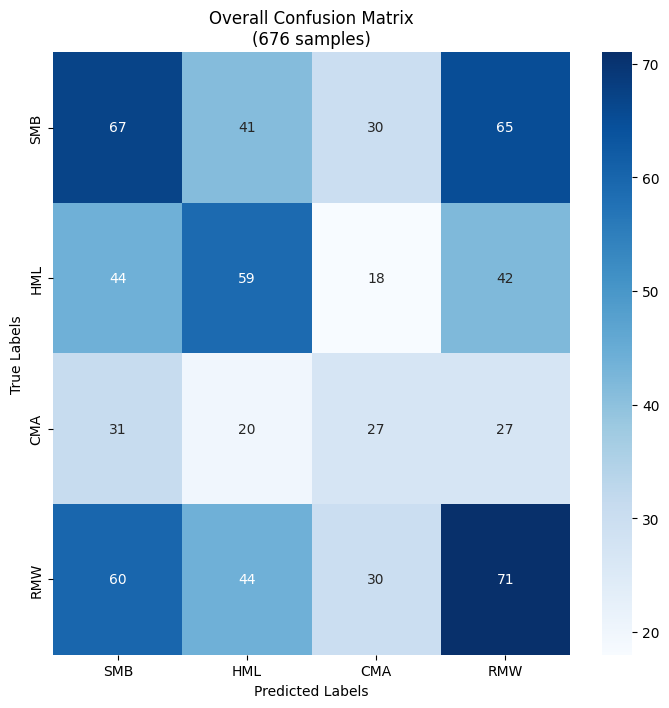

Regime,Accuracy,Precision,Recall,F1 Score,Samples
Overall,0.3314,0.3313,0.3314,0.3313,676


Factor,Predicted Count,Correct Count,Factor Accuracy (%)
SMB,202,67,33.17%
HML,164,59,35.98%
CMA,105,27,25.71%
RMW,205,71,34.63%


In [53]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML

# ----- Part A: Confusion Matrix & Overall Performance Metrics -----

# Use FACTORS directly as labels
labels = FACTORS

# Extract actual and predicted winners
all_true = results_df['Actual_Winner']
all_pred = results_df['Predicted_Winner']

# Get unique regimes if regime split is active
if use_regime_split:
    all_regimes = results_df['Regime'].unique()
else:
    all_regimes = []

# Set number of subplots: one overall plus one per regime if needed
num_cols = 1 if not use_regime_split else len(all_regimes) + 1
fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(8 if num_cols == 1 else 19.5, 8))
if num_cols == 1:
    axes = [axes]

# 1. Overall confusion matrix
cm_total = confusion_matrix(all_true, all_pred, labels=labels)
sns.heatmap(cm_total, annot=True, fmt='d', cmap="Blues",
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_xlabel("Predicted Labels")
axes[0].set_ylabel("True Labels")
total_samples = len(all_true)
axes[0].set_title(f"Overall Confusion Matrix\n({total_samples} samples)")

# Prepare a list for metrics summary
metrics_summary = []

# Overall metrics
overall_metrics = {
    "Regime": "Overall",
    "Accuracy": accuracy_score(all_true, all_pred),
    "Precision": precision_score(all_true, all_pred, average='weighted', zero_division=0),
    "Recall": recall_score(all_true, all_pred, average='weighted', zero_division=0),
    "F1 Score": f1_score(all_true, all_pred, average='weighted', zero_division=0),
    "Samples": total_samples
}
metrics_summary.append(overall_metrics)

# 2. Per-regime confusion matrices and metrics (if regime split is active)
if use_regime_split:
    for i, regime in enumerate(all_regimes):
        regime_mask = (results_df['Regime'] == regime)
        regime_true = all_true[regime_mask]
        regime_pred = all_pred[regime_mask]

        if len(regime_true) == 0:
            print(f"\nNo samples for regime '{regime}'. Skipping confusion matrix.")
            continue

        cm_regime = confusion_matrix(regime_true, regime_pred, labels=labels)
        sns.heatmap(cm_regime, annot=True, fmt='d', cmap="Blues",
                    xticklabels=labels, yticklabels=labels, ax=axes[i+1])
        axes[i+1].set_xlabel("Predicted Labels")
        axes[i+1].set_ylabel("True Labels")
        axes[i+1].set_title(f"{regime} Regime\n({len(regime_true)} samples)")

        regime_metrics = {
            "Regime": regime,
            "Accuracy": accuracy_score(regime_true, regime_pred),
            "Precision": precision_score(regime_true, regime_pred, average='weighted', zero_division=0),
            "Recall": recall_score(regime_true, regime_pred, average='weighted', zero_division=0),
            "F1 Score": f1_score(regime_true, regime_pred, average='weighted', zero_division=0),
            "Samples": len(regime_true)
        }
        metrics_summary.append(regime_metrics)

plt.tight_layout(pad=4.0)
plt.subplots_adjust(wspace=0.3)
plt.show()

# Convert overall metrics summary to DataFrame and round values
metrics_df = pd.DataFrame(metrics_summary)
metrics_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']] = metrics_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].round(4)

# Build HTML table for overall performance metrics
html_overall = f"""
<h3>Overall Performance Metrics Summary</h3>
<table border="1" cellpadding="5">
    <tr>
        <th>Regime</th>
        <th>Accuracy</th>
        <th>Precision</th>
        <th>Recall</th>
        <th>F1 Score</th>
        <th>Samples</th>
    </tr>
"""
for _, row in metrics_df.iterrows():
    html_overall += f"""
    <tr>
        <td>{row['Regime']}</td>
        <td>{row['Accuracy']}</td>
        <td>{row['Precision']}</td>
        <td>{row['Recall']}</td>
        <td>{row['F1 Score']}</td>
        <td>{row['Samples']}</td>
    </tr>
"""
html_overall += "</table>"

explanations = {
    "Accuracy": "Proportion of correct predictions.",
    "Precision": "How many predicted positives were actually correct?",
    "Recall": "How many actual positives were correctly predicted?",
    "F1 Score": "Harmonic mean of precision & recall.",
    "Samples": "Number of test samples in this regime."
}
html_overall += "<h4>Metric Explanations:</h4><ul>"
for metric, desc in explanations.items():
    html_overall += f"<li><strong>{metric}:</strong> {desc}</li>"
html_overall += "</ul>"

display(HTML(html_overall))


# ----- Part B: Factor-Level Accuracy from Overall Confusion Matrix -----
factor_data = []
for i, factor in enumerate(labels):
    predicted_count = cm_total[:, i].sum()  # sum of column i
    correct_count = cm_total[i, i]         # diagonal entry
    if predicted_count > 0:
        factor_accuracy = correct_count / predicted_count * 100
    else:
        factor_accuracy = 0.0

    factor_data.append({
        "Factor": factor,
        "Predicted Count": int(predicted_count),
        "Correct Count": int(correct_count),
        "Factor Accuracy (%)": round(factor_accuracy, 2)
    })

factor_df = pd.DataFrame(factor_data)

html_factor = f"""
<h3>Factor-Level Accuracy (From Overall Confusion Matrix)</h3>
<table border="1" cellpadding="5">
    <tr>
        <th>Factor</th>
        <th>Predicted Count</th>
        <th>Correct Count</th>
        <th>Factor Accuracy (%)</th>
    </tr>
"""
for _, row in factor_df.iterrows():
    html_factor += f"""
    <tr>
        <td>{row['Factor']}</td>
        <td>{row['Predicted Count']}</td>
        <td>{row['Correct Count']}</td>
        <td>{row['Factor Accuracy (%)']}%</td>
    </tr>
"""
html_factor += "</table>"

html_factor += """
<h4>Definition</h4>
<ul>
  <li><strong>Predicted Count:</strong> Sum of the corresponding column in the confusion matrix (times predicted this factor).</li>
  <li><strong>Correct Count:</strong> Diagonal entry for this factor in the matrix (times predicted factor = actual factor).</li>
  <li><strong>Factor Accuracy:</strong> (Correct Count / Predicted Count) * 100.</li>
</ul>
"""

display(HTML(html_factor))


##Feature importance

<ipython-input-54-d99f00845294>:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=4.0)


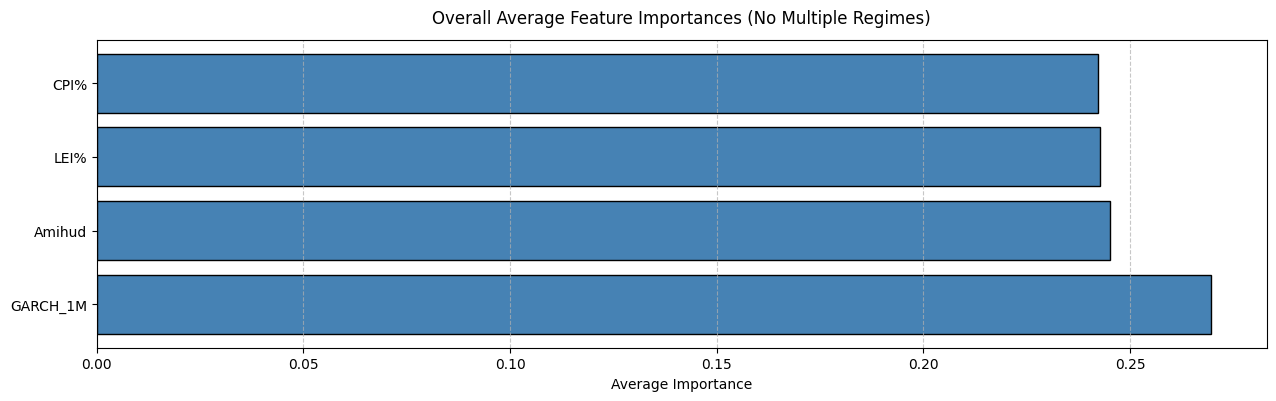

In [54]:
# --- Code cell 26 ---
# 2. Regime-Specific Feature Importances (Dynamic Version)
# ========================================================

import numpy as np
import matplotlib.pyplot as plt

# Get the unique regimes from results_df (already converted to string names)
existing_regimes = results_df['Regime'].unique()
n_regimes = len(existing_regimes)

# Dynamically get the number of features from the data
n_features = len(results_df['Feature_Importances'].iloc[0])  # Actual feature count

# Robust feature name handling:
try:
    # Validate FEATURES list length matches actual features
    if len(FEATURES) != n_features:
        print(f"⚠️ Warning: FEATURES list length ({len(FEATURES)}) doesn't match model features ({n_features})")
        print("Using auto-generated feature names instead")
        raise ValueError
    feature_names = FEATURES
except (NameError, ValueError):
    # Generate descriptive feature names if there's a mismatch or error
    feature_names = [f'Feature {i+1}' for i in range(n_features)]
    print(f"Using auto-generated feature names for {n_features} features")

# Compute overall average feature importances across all predictions
overall_avg_fi = np.vstack(results_df['Feature_Importances'].values).mean(axis=0)

# Calculate regime-specific average feature importances
regime_avg_fi = {}
for regime_name in existing_regimes:
    regime_df = results_df[results_df['Regime'] == regime_name]
    regime_fi_array = np.vstack(regime_df['Feature_Importances'].values)
    regime_avg_fi[regime_name] = regime_fi_array.mean(axis=0)

# Sort features by overall importance in descending order
sorted_idx = overall_avg_fi.argsort()[::-1]
sorted_idx = sorted_idx[sorted_idx < len(feature_names)]  # bounds check
sorted_features = [feature_names[i] for i in sorted_idx]

# 1) If we have more than one unique regime, make an overall + multiple regime subplots
if n_regimes > 1:
    total_plots = 1 + n_regimes  # One for overall, one per regime
    # Figure height depends on number of plots and number of features
    row_height = max(0.3 * n_features, 4)
    fig, axs = plt.subplots(
        total_plots,
        1,
        figsize=(19.5, total_plots * row_height),
        gridspec_kw={'hspace': 0.4}
    )
    if total_plots == 1:
        axs = [axs]  # ensure iterable

    # --- Overall Feature Importances ---
    axs[0].barh(
        np.arange(n_features),
        overall_avg_fi[sorted_idx],
        color='steelblue',
        edgecolor='black'
    )
    axs[0].set_yticks(np.arange(n_features))
    axs[0].set_yticklabels(sorted_features)
    axs[0].set_title("Overall Average Feature Importances", pad=12)
    axs[0].set_xlabel("Average Importance")
    axs[0].grid(axis='x', linestyle='--', alpha=0.7)

    # --- Regime-Specific Plots ---
    for idx, (regime_name, avg_fi) in enumerate(regime_avg_fi.items(), start=1):
        sorted_regime_fi = avg_fi[sorted_idx]
        axs[idx].barh(
            np.arange(n_features),
            sorted_regime_fi,
            color='salmon',
            edgecolor='black'
        )
        axs[idx].set_yticks(np.arange(n_features))
        axs[idx].set_yticklabels(sorted_features)
        axs[idx].set_title(f"Feature Importances: {regime_name} Regime", pad=12)
        axs[idx].set_xlabel("Average Importance")
        axs[idx].grid(axis='x', linestyle='--', alpha=0.7)

# 2) Otherwise, if there's only zero or one regime, show only the overall chart
else:
    total_plots = 1
    row_height = max(0.3 * n_features, 4)
    fig, ax = plt.subplots(
        1, 1, figsize=(19.5, row_height),
        gridspec_kw={'hspace': 0.4}
    )

    # --- Overall Feature Importances ---
    ax.barh(
        np.arange(n_features),
        overall_avg_fi[sorted_idx],
        color='steelblue',
        edgecolor='black'
    )
    ax.set_yticks(np.arange(n_features))
    ax.set_yticklabels(sorted_features)
    ax.set_title("Overall Average Feature Importances (No Multiple Regimes)", pad=12)
    ax.set_xlabel("Average Importance")
    ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout(pad=4.0)
plt.subplots_adjust(left=0.3)  # Provide extra space on the left for feature labels
plt.show()


##Allocation chart

Date Range: 1968-08-30 00:00:00 to 2024-11-30 00:00:00


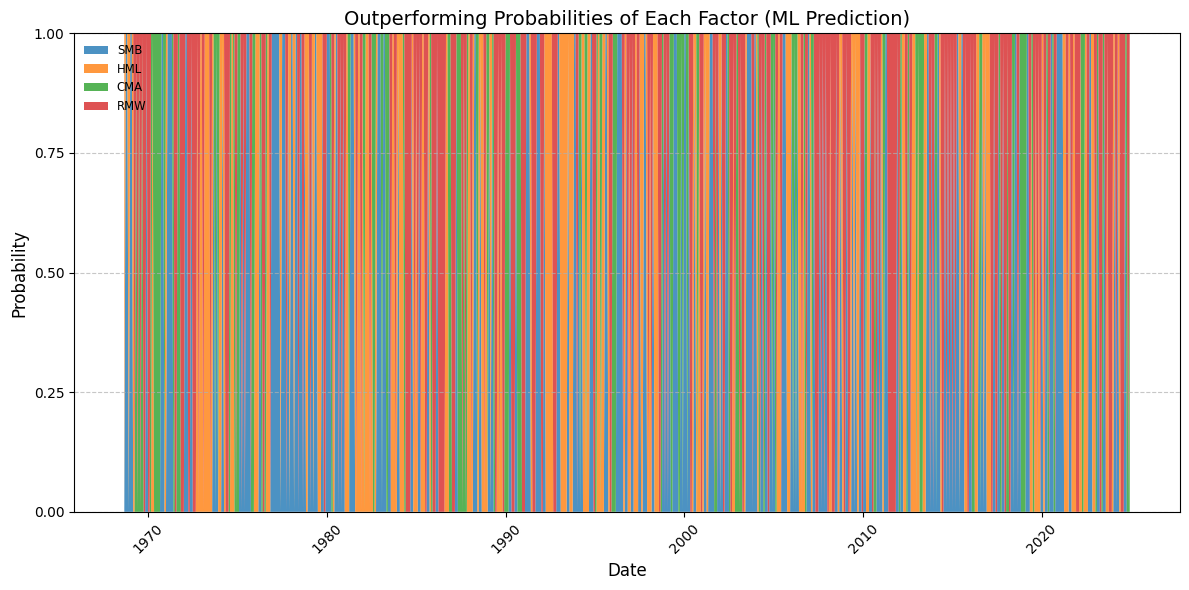

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Convert "Predicted_month" to datetime (assuming the format is '%Y-%m'):
probability_dates = pd.to_datetime(
    results_df["Predicted_month"],
    format='%Y-%m'
)

# 2) Drop rows with unparseable dates if needed
if probability_dates.isna().any():
    print("Warning: Some dates could not be parsed. Dropping those rows.")
    results_df = results_df.loc[~probability_dates.isna()].copy()
    probability_dates = probability_dates.dropna()

# 3) Extract the probability arrays and build a DataFrame
full_probs = np.vstack(results_df["Predicted_Probabilities"].values)
probability_df = pd.DataFrame(full_probs, columns=FACTORS)
probability_df["Date"] = probability_dates
probability_df = probability_df.sort_values("Date").reset_index(drop=True)

# 4) Check date range
print("Date Range:", probability_df["Date"].min(), "to", probability_df["Date"].max())

# 5) Plot the probabilities in a stack plot
plt.figure(figsize=(12, 6))
plt.stackplot(
    probability_df["Date"],
    [probability_df[col] for col in FACTORS],
    labels=FACTORS,
    alpha=0.8
)

plt.title("Outperforming Probabilities of Each Factor (ML Prediction)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Probability", fontsize=12)

# Manually set y-axis ticks at 0, 0.25, 0.5, 0.75, 1
plt.ylim(0, 1)
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

plt.legend(loc='upper left', fontsize='small', frameon=False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Factor weight analysis

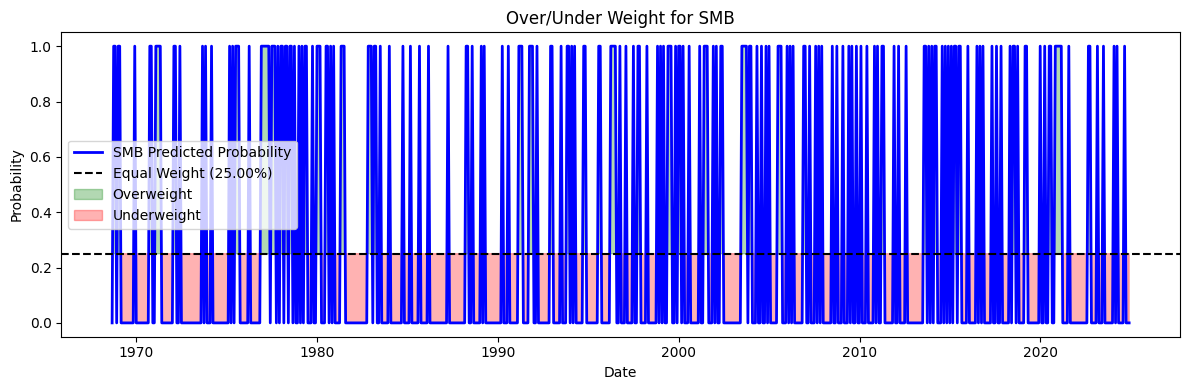

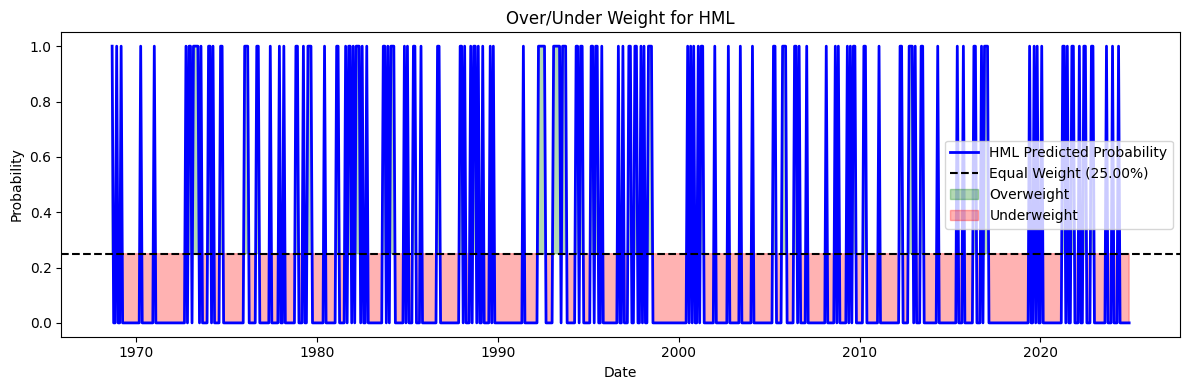

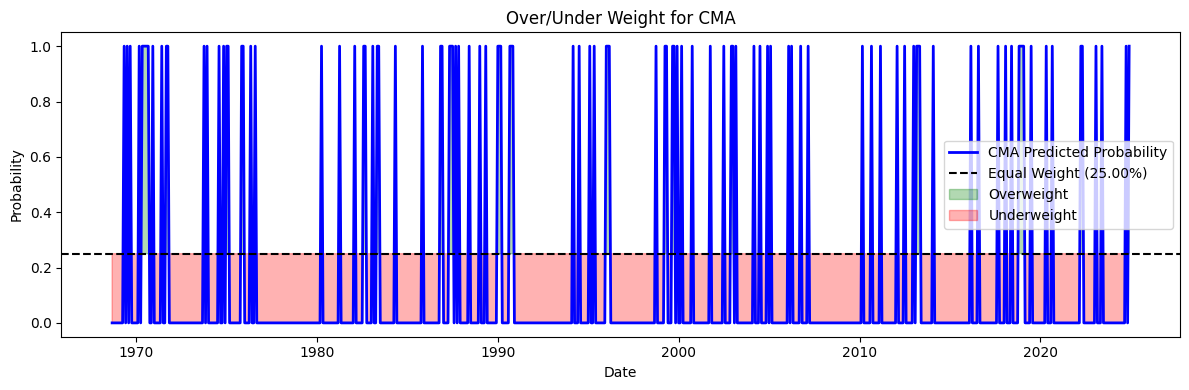

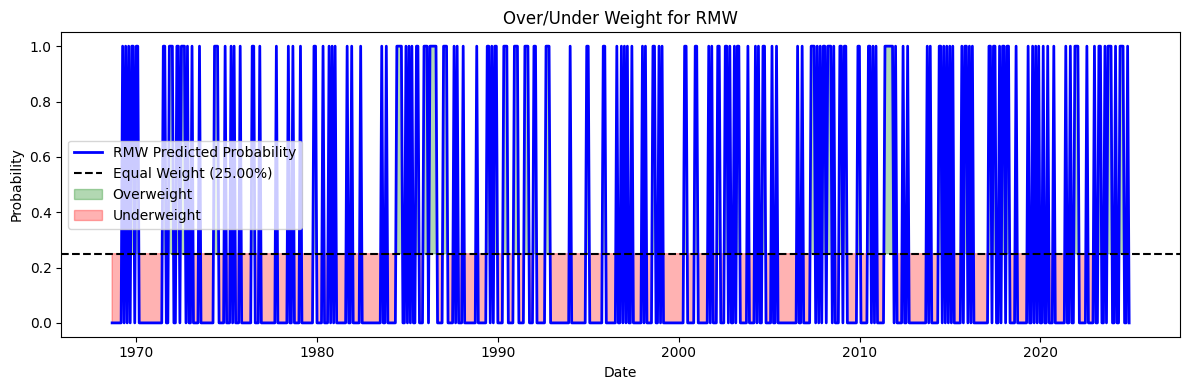

In [56]:
# Set the date range for viewing
start_date = "1968-07-30"
end_date = "2024-11-30"

# Ensure that the "Date" column is in datetime format if it's not already
probability_df["Date"] = pd.to_datetime(probability_df["Date"])

# Filter the dataframe to include only the rows between the set dates
mask = (probability_df["Date"] >= start_date) & (probability_df["Date"] <= end_date)
filtered_df = probability_df.loc[mask]

# Define the equal weight value (static equal weight for each factor)
equal_weight = 1 / len(FACTORS)  # For example, if 5 factors then equal_weight = 0.20

import matplotlib.pyplot as plt

# Loop over each factor in FACTORS and create a separate chart
for factor in FACTORS:
    plt.figure(figsize=(12, 4))

    # Plot the predicted probability for the current factor using the filtered data
    plt.plot(filtered_df["Date"], filtered_df[factor],
             label=f"{factor} Predicted Probability", color='blue', linewidth=2)

    # Plot the static equal weight line
    plt.axhline(equal_weight, color='black', linestyle='--',
                label=f"Equal Weight ({equal_weight:.2%})")

    # Shade the area where the predicted probability is above the equal weight (Overweight)
    plt.fill_between(filtered_df["Date"],
                     filtered_df[factor],
                     equal_weight,
                     where=(filtered_df[factor] > equal_weight),
                     interpolate=True, color='green', alpha=0.3, label='Overweight')

    # Shade the area where the predicted probability is below the equal weight (Underweight)
    plt.fill_between(filtered_df["Date"],
                     filtered_df[factor],
                     equal_weight,
                     where=(filtered_df[factor] < equal_weight),
                     interpolate=True, color='red', alpha=0.3, label='Underweight')

    # Set chart title and labels
    plt.title(f"Over/Under Weight for {factor}")
    plt.xlabel("Date")
    plt.ylabel("Probability")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()


##Total outperforming probabilities

In [57]:
import pandas as pd

avg_probs = probability_df[FACTORS].mean()
avg_probs_df = avg_probs.reset_index()
avg_probs_df.columns = ['Factor', 'Average Probability']


print("Average Outperforming Probabilities Over Time:")
print(avg_probs_df)

Average Outperforming Probabilities Over Time:
  Factor  Average Probability
0    SMB             0.298817
1    HML             0.242604
2    CMA             0.155325
3    RMW             0.303254


##Return data df

In [58]:
import pandas as pd

# Ensure 'Predicted_month' is datetime and merge results with df_sorted on Date
results_df['Predicted_month'] = pd.to_datetime(results_df['Predicted_month'])
results_df_local = results_df.copy().merge(df_sorted, left_on='Predicted_month', right_on='Date', how='left')

# Print row-match info
print(f"Initial results_df rows: {len(results_df)}")
print(f"Initial df_sorted rows: {len(df_sorted)}")
print(f"Matched rows: {results_df_local['Date'].notna().sum()}")
print(f"Unmatched rows: {results_df_local['Date'].isna().sum()}")

# Define columns to keep (with 'Predicted_month' first)
cols = ['Predicted_month', 'Allocated_Return', 'Equal_Weight_Return', 'Mkt', 'RF', 'Mkt-RF', 'Us_standard', 'Predicted_Winner'] + FACTORS
results_df_local = results_df_local[[c for c in cols if c in results_df_local.columns]] \
                    .sort_values('Predicted_month').reset_index(drop=True)

display(results_df_local)
print("\nFirst date in 'Predicted_month':", results_df['Predicted_month'].min())
print("Last date in 'Predicted_month':", results_df['Predicted_month'].max())


Initial results_df rows: 676
Initial df_sorted rows: 736
Matched rows: 676
Unmatched rows: 0


,Predicted_month,Allocated_Return,Equal_Weight_Return,Mkt,RF,Mkt-RF,Predicted_Winner,SMB,HML,CMA,RMW
0,1968-08-30,0.0101,0.007650,0.0176,0.0042,0.0134,HML,0.0227,0.0101,0.0048,-0.0070
1,1968-09-30,0.0281,0.004975,0.0446,0.0043,0.0403,SMB,0.0281,0.0030,0.0087,-0.0199
2,1968-10-30,-0.0042,0.009550,0.0086,0.0044,0.0042,SMB,-0.0042,0.0286,0.0270,-0.0132
3,1968-11-30,-0.0092,-0.001325,0.0585,0.0042,0.0543,HML,0.0239,-0.0092,-0.0243,0.0043
4,1968-12-30,0.0352,0.008525,-0.0351,0.0043,-0.0394,SMB,0.0352,-0.0001,0.0176,-0.0186
...,...,...,...,...,...,...,...,...,...,...,...
671,2024-07-30,0.0022,0.036675,0.0169,0.0045,0.0124,RMW,0.0828,0.0574,0.0043,0.0022
672,2024-08-30,-0.0365,-0.007675,0.0209,0.0048,0.0161,SMB,-0.0365,-0.0113,0.0086,0.0085
673,2024-09-30,-0.0026,-0.009575,0.0214,0.0040,0.0174,CMA,-0.0102,-0.0259,-0.0026,0.0004
674,2024-10-30,-0.0138,-0.000850,-0.0058,0.0039,-0.0097,RMW,-0.0088,0.0089,0.0103,-0.0138



First date in 'Predicted_month': 1968-08-30 00:00:00
Last date in 'Predicted_month': 2024-11-30 00:00:00


In [59]:
import pandas as pd

# Filter the DataFrame between specified dates
start_date = pd.to_datetime('2000-01-01')
end_date   = pd.to_datetime('2024-12-30')
df_filtered = results_df_local[(results_df_local['Predicted_month'] >= start_date) &
                               (results_df_local['Predicted_month'] <= end_date)].copy()

# Rename columns if present
rename_dict = {}
if 'Allocated_Return' in df_filtered.columns:
    rename_dict['Allocated_Return'] = 'ML Allocated Strategy Return'
if BENCHMARK[0] in df_filtered.columns:
    rename_dict[BENCHMARK[0]] = 'Benchmark Return'
df_filtered.rename(columns=rename_dict, inplace=True)

# Calculate equal-weighted returns based on FACTORS (e.g. ['SMB','HML','CMA','RMW'])
factors_exRF = [f for f in FACTORS if f in df_filtered.columns]
if 'RF' in df_filtered.columns:
    # Two versions: excluding and including RF
    factors_inRF = factors_exRF + ['RF']
    df_filtered['Equal Factor Weight Strategy Return ExRF'] = df_filtered[factors_exRF].mean(axis=1)
    df_filtered['Equal Factor Weight Strategy Return InclRF'] = df_filtered[factors_inRF].mean(axis=1)
else:
    df_filtered['Equal Factor Weight Strategy Return'] = df_filtered[factors_exRF].mean(axis=1)

# ===== NEW CODE: Calculate strategy with 50% weight on predicted winner =====
def calc_winner_strategy(row):
    # Get the predicted winner factor
    pred = row['Predicted_Winner']
    # Check if the predicted factor is among the factors
    if pred in factors_exRF:
        # Identify the other factors
        other_factors = [f for f in factors_exRF if f != pred]
        if len(other_factors) > 0:
            # 50% weight on predicted winner and 50% equally split among the others
            return 0.5 * row[pred] + 0.5 * row[other_factors].mean()
        else:
            return row[pred]
    else:
        # If predicted winner is not in factors, default to equal weight return
        return row[factors_exRF].mean()

df_filtered['Predicted Winner Weighted Strategy Return'] = df_filtered.apply(calc_winner_strategy, axis=1)
# ===== END NEW CODE =====

# Build monthly returns table (only keep existing columns)
if 'RF' in df_filtered.columns:
    base_cols = ['Predicted_month', 'ML Allocated Strategy Return',
                 'Equal Factor Weight Strategy Return ExRF', 'Equal Factor Weight Strategy Return InclRF',
                 'Benchmark Return', 'Predicted Winner Weighted Strategy Return']
else:
    base_cols = ['Predicted_month', 'ML Allocated Strategy Return',
                 'Equal Factor Weight Strategy Return', 'Benchmark Return', 'Predicted Winner Weighted Strategy Return']
returns_table = df_filtered[[c for c in base_cols if c in df_filtered.columns]].copy()

# Compute cumulative returns using cumprod and subtract 1
cum = returns_table.copy()
if 'ML Allocated Strategy Return' in cum.columns:
    cum['ML Cumulative Allocated Return'] = (1 + cum['ML Allocated Strategy Return']).cumprod() - 1
if 'Equal Factor Weight Strategy Return ExRF' in cum.columns:
    cum['Equal Factor Weight Cumulative Return ExRF'] = (1 + cum['Equal Factor Weight Strategy Return ExRF']).cumprod() - 1
    cum['Equal Factor Weight Cumulative Return InclRF'] = (1 + cum['Equal Factor Weight Strategy Return InclRF']).cumprod() - 1
elif 'Equal Factor Weight Strategy Return' in cum.columns:
    cum['Equal Factor Weight Cumulative Return'] = (1 + cum['Equal Factor Weight Strategy Return']).cumprod() - 1
if 'Benchmark Return' in cum.columns:
    cum['Benchmark Cumulative Return'] = (1 + cum['Benchmark Return']).cumprod() - 1
# ===== NEW CODE: Cumulative returns for Predicted Winner Weighted Strategy =====
if 'Predicted Winner Weighted Strategy Return' in cum.columns:
    cum['Predicted Winner Weighted Cumulative Return'] = (1 + cum['Predicted Winner Weighted Strategy Return']).cumprod() - 1
# ===== END NEW CODE =====

# Keep only desired cumulative columns and sort by date
if 'Equal Factor Weight Strategy Return ExRF' in cum.columns:
    desired = ['Predicted_month', 'ML Cumulative Allocated Return',
               'Equal Factor Weight Cumulative Return ExRF', 'Equal Factor Weight Cumulative Return InclRF',
               'Benchmark Cumulative Return', 'Predicted Winner Weighted Cumulative Return']
else:
    desired = ['Predicted_month', 'ML Cumulative Allocated Return',
               'Equal Factor Weight Cumulative Return', 'Benchmark Cumulative Return',
               'Predicted Winner Weighted Cumulative Return']
cumulative_table = cum[[c for c in desired if c in cum.columns]].sort_values('Predicted_month').reset_index(drop=True)

# Display results
print("Returns Table:")
display(returns_table)
print("Cumulative Returns Table:")
display(cumulative_table)


Returns Table:


,Predicted_month,ML Allocated Strategy Return,Equal Factor Weight Strategy Return ExRF,Equal Factor Weight Strategy Return InclRF,Benchmark Return,Predicted Winner Weighted Strategy Return
377,2000-01-30,0.0442,0.002425,0.00276,-0.0433,0.016350
378,2000-02-29,-0.0048,-0.026100,-0.02002,0.0288,-0.019000
379,2000-03-30,-0.1532,0.007525,0.00696,0.0567,-0.046050
380,2000-04-30,0.0766,0.038900,0.03204,-0.0594,0.051467
381,2000-05-30,0.0413,0.016100,0.01388,-0.0392,0.024500
...,...,...,...,...,...,...
671,2024-07-30,0.0022,0.036675,0.03024,0.0169,0.025183
672,2024-08-30,-0.0365,-0.007675,-0.00518,0.0209,-0.017283
673,2024-09-30,-0.0026,-0.009575,-0.00686,0.0214,-0.007250
674,2024-10-30,-0.0138,-0.000850,0.00010,-0.0058,-0.005167


Cumulative Returns Table:


,Predicted_month,ML Cumulative Allocated Return,Equal Factor Weight Cumulative Return ExRF,Equal Factor Weight Cumulative Return InclRF,Benchmark Cumulative Return,Predicted Winner Weighted Cumulative Return
0,2000-01-30,0.044200,0.002425,0.002760,-0.043300,0.016350
1,2000-02-29,0.039188,-0.023738,-0.017315,-0.015747,-0.002961
2,2000-03-30,-0.120016,-0.016392,-0.010476,0.040060,-0.048874
3,2000-04-30,-0.052609,0.021870,0.021229,-0.021719,0.000077
4,2000-05-30,-0.013482,0.038323,0.035403,-0.060068,0.024579
...,...,...,...,...,...,...
294,2024-07-30,1.446649,1.192756,1.053066,5.132815,1.317853
295,2024-08-30,1.357346,1.175927,1.042432,5.260991,1.277793
296,2024-09-30,1.351217,1.155092,1.028420,5.394976,1.261279
297,2024-10-30,1.318770,1.153260,1.028623,5.357885,1.249596


##Cumulative returns chart

Updated plotting range: 2000-01-30 00:00:00 to 2024-11-30 00:00:00
Columns available for plotting: ['Predicted_month', 'ML Cumulative Allocated Return', 'Equal Factor Weight Cumulative Return ExRF', 'Equal Factor Weight Cumulative Return InclRF', 'Benchmark Cumulative Return', 'Predicted Winner Weighted Cumulative Return']


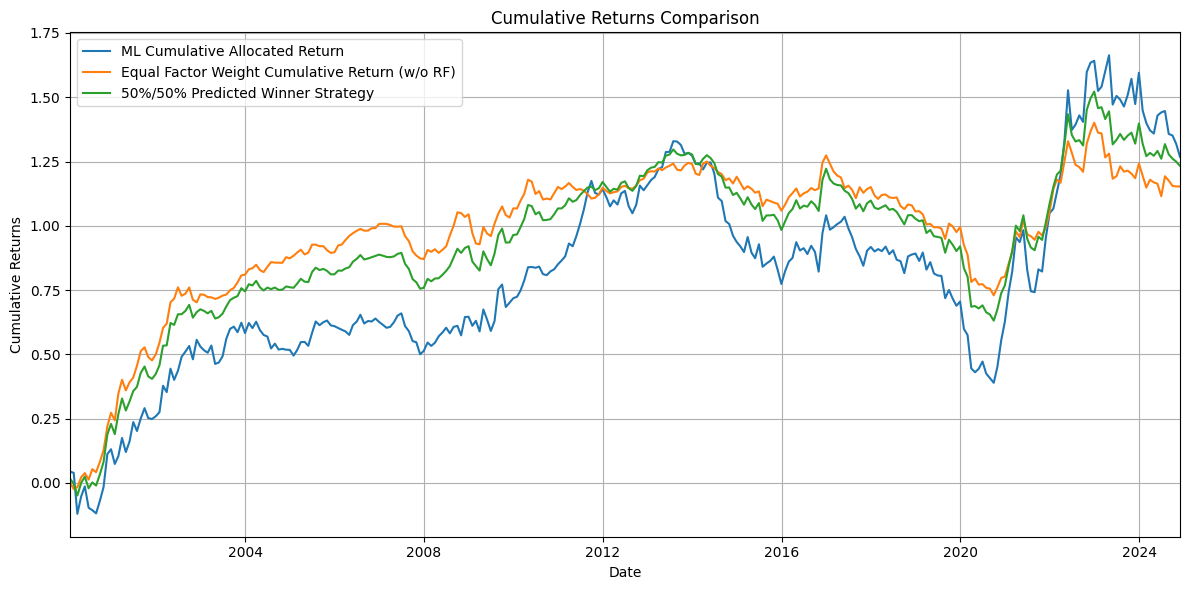

In [60]:
import matplotlib.pyplot as plt

# Toggle: Show 50%/50% strategy line or not
show_50_50_strategy = True  # Set to False to hide it

# Ensure cumulative_table is up-to-date
df_plot = cumulative_table.copy()

# Debug: Print min/max dates to ensure they have updated correctly
start_date = df_plot['Predicted_month'].min()
end_date = df_plot['Predicted_month'].max()
print(f"Updated plotting range: {start_date} to {end_date}")
print("Columns available for plotting:", df_plot.columns.tolist())

# If dates did not extend, print warning
if start_date == end_date:
    print("⚠ Warning: The dataset might not have updated properly. Try rerunning the previous cell!")

# Ensure new figure is created and not affected by previous runs
plt.figure(figsize=(12, 6))
plt.clf()  # Clears the figure to reset the plot

# Plot ML Cumulative Allocated Return
if 'ML Cumulative Allocated Return' in df_plot.columns:
    plt.plot(df_plot['Predicted_month'], df_plot['ML Cumulative Allocated Return'], label='ML Cumulative Allocated Return')

# Plot Equal Factor Weight Cumulative Return(s) - Always show ExRF, but InclRF only if RF is in FACTORS
if 'Equal Factor Weight Cumulative Return ExRF' in df_plot.columns:
    plt.plot(df_plot['Predicted_month'], df_plot['Equal Factor Weight Cumulative Return ExRF'],
             label='Equal Factor Weight Cumulative Return (w/o RF)')

if 'RF' in FACTORS and 'Equal Factor Weight Cumulative Return InclRF' in df_plot.columns:
    plt.plot(df_plot['Predicted_month'], df_plot['Equal Factor Weight Cumulative Return InclRF'],
             label='Equal Factor Weight Cumulative Return (w/ RF)')

# Plot Benchmark if show_benchmark is True and column exists
if show_benchmark and 'Benchmark Cumulative Return' in df_plot.columns:
    plt.plot(df_plot['Predicted_month'], df_plot['Benchmark Cumulative Return'], label='Benchmark Cumulative Return')

# Plot Predicted Winner Weighted Cumulative Return if toggle is active
if show_50_50_strategy and 'Predicted Winner Weighted Cumulative Return' in df_plot.columns:
    plt.plot(df_plot['Predicted_month'], df_plot['Predicted Winner Weighted Cumulative Return'],
             label='50%/50% Predicted Winner Strategy')

plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Comparison')

# Ensure x-axis extends dynamically to new data
plt.xlim(df_plot['Predicted_month'].min(), df_plot['Predicted_month'].max())

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##PERFORMANCE METRICS

In [61]:

import numpy as np
import pandas as pd

# --- PERFORMANCE METRICS ---

# For the ML Allocated Strategy:
ml_returns = merged_df['ML Allocated Strategy Return']
ml_mean_monthly = ml_returns.mean()
ml_std_monthly  = ml_returns.std()
ml_annualized_return = ml_mean_monthly * 12
ml_annualized_vol    = ml_std_monthly * np.sqrt(12)
ml_sharpe            = ml_annualized_return / ml_annualized_vol

print("\nPERFORMANCE METRICS:\n")
print("ML Allocated Strategy:")
print(f"  Annualized Return:      {ml_annualized_return:.2%}")
print(f"  Annualized Volatility:  {ml_annualized_vol:.2%}")
print(f"  Sharpe Ratio:           {ml_sharpe:.2f}\n")

# For the Benchmark Strategy:
# Compute benchmark monthly returns from the rebased cumulative series
benchmark_returns = merged_df['Benchmark Cumulative Returns Rebased'].pct_change().fillna(0)
benchmark_mean_monthly = benchmark_returns.mean()
benchmark_std_monthly  = benchmark_returns.std()
benchmark_annualized_return = benchmark_mean_monthly * 12
benchmark_annualized_vol = benchmark_std_monthly * np.sqrt(12)
benchmark_sharpe = benchmark_annualized_return / benchmark_annualized_vol

print("Benchmark Strategy:")
print(f"  Annualized Return:      {benchmark_annualized_return:.2%}")
print(f"  Annualized Volatility:  {benchmark_annualized_vol:.2%}")
print(f"  Sharpe Ratio:           {benchmark_sharpe:.2f}\n")

# For the Equal Factor Weight Strategy:
if 'RF' in FACTORS:
    # With RF
    equal_returns_with_rf = merged_df['Equal Factor Weight Strategy w/ RF']
    equal_mean_monthly_with_rf = equal_returns_with_rf.mean()
    equal_std_monthly_with_rf  = equal_returns_with_rf.std()
    equal_annualized_return_with_rf = equal_mean_monthly_with_rf * 12
    equal_annualized_vol_with_rf    = equal_std_monthly_with_rf * np.sqrt(12)
    equal_sharpe_with_rf            = equal_annualized_return_with_rf / equal_annualized_vol_with_rf

    print("Equal Factor Weight Strategy (with RF):")
    print(f"  Annualized Return:      {equal_annualized_return_with_rf:.2%}")
    print(f"  Annualized Volatility:  {equal_annualized_vol_with_rf:.2%}")
    print(f"  Sharpe Ratio:           {equal_sharpe_with_rf:.2f}\n")

    # Without RF
    equal_returns_without_rf = merged_df['Equal Factor Weight Strategy w/o RF']
    equal_mean_monthly_without_rf = equal_returns_without_rf.mean()
    equal_std_monthly_without_rf  = equal_returns_without_rf.std()
    equal_annualized_return_without_rf = equal_mean_monthly_without_rf * 12
    equal_annualized_vol_without_rf    = equal_std_monthly_without_rf * np.sqrt(12)
    equal_sharpe_without_rf            = equal_annualized_return_without_rf / equal_annualized_vol_without_rf

    print("Equal Factor Weight Strategy (without RF):")
    print(f"  Annualized Return:      {equal_annualized_return_without_rf:.2%}")
    print(f"  Annualized Volatility:  {equal_annualized_vol_without_rf:.2%}")
    print(f"  Sharpe Ratio:           {equal_sharpe_without_rf:.2f}\n")
else:
    equal_returns = merged_df['Equal Factor Weight Strategy']
    equal_mean_monthly = equal_returns.mean()
    equal_std_monthly  = equal_returns.std()
    equal_annualized_return = equal_mean_monthly * 12
    equal_annualized_vol    = equal_std_monthly * np.sqrt(12)
    equal_sharpe            = equal_annualized_return / equal_annualized_vol

    print("Equal Factor Weight Strategy:")
    print(f"  Annualized Return:      {equal_annualized_return:.2%}")
    print(f"  Annualized Volatility:  {equal_annualized_vol:.2%}")
    print(f"  Sharpe Ratio:           {equal_sharpe:.2f}\n")

# --- MAXIMUM DRAWDOWN CALCULATIONS ---
# Compute wealth indexes starting at 1 for each strategy.
wealth_ml = (1 + merged_df['ML Allocated Strategy Return']).cumprod()
wealth_benchmark = (1 + benchmark_returns).cumprod()

if 'RF' in FACTORS:
    wealth_equal_with_rf = (1 + merged_df['Equal Factor Weight Strategy w/ RF']).cumprod()
    wealth_equal_without_rf = (1 + merged_df['Equal Factor Weight Strategy w/o RF']).cumprod()
else:
    wealth_equal = (1 + merged_df['Equal Factor Weight Strategy']).cumprod()

# Compute drawdown series for each strategy:
drawdown_ml = wealth_ml / wealth_ml.cummax() - 1
drawdown_benchmark = wealth_benchmark / wealth_benchmark.cummax() - 1

if 'RF' in FACTORS:
    drawdown_equal_with_rf = wealth_equal_with_rf / wealth_equal_with_rf.cummax() - 1
    drawdown_equal_without_rf = wealth_equal_without_rf / wealth_equal_without_rf.cummax() - 1
else:
    drawdown_equal = wealth_equal / wealth_equal.cummax() - 1

print("MAXIMUM DRAWDOWNS:\n")
print("ML Allocated Strategy Max Drawdown:       ", f"{drawdown_ml.min():.2%}")
print("Benchmark Strategy Max Drawdown:            ", f"{drawdown_benchmark.min():.2%}")
if 'RF' in FACTORS:
    print("Equal Factor Weight Strategy (with RF) Max Drawdown:  ", f"{drawdown_equal_with_rf.min():.2%}")
    print("Equal Factor Weight Strategy (without RF) Max Drawdown:  ", f"{drawdown_equal_without_rf.min():.2%}")
else:
    print("Equal Factor Weight Strategy Max Drawdown:  ", f"{drawdown_equal.min():.2%}")


NameError: name 'merged_df' is not defined

##Drawdown chart

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Toggle Options (set these before any calculations) ---
show_benchmark_drawdown = True

# For Equal Factor Weight Drawdown toggles:
if 'RF' in FACTORS:
    show_equal_weight_drawdown_rf = True    # Toggle for Equal Weight drawdown (with RF)
    show_equal_weight_drawdown_no_rf = True   # Toggle for Equal Weight drawdown (without RF)
else:
    show_equal_weight_drawdown = True         # Toggle for Equal Weight drawdown

# --- Compute Drawdowns for Each Strategy ---
# ML Allocated Strategy Drawdown (using the ML Cumulative Allocated Return)
merged_df['ML Drawdown'] = merged_df['ML Cumulative Allocated Return'] / merged_df['ML Cumulative Allocated Return'].cummax() - 1

# Benchmark Drawdown (using the Benchmark Cumulative Returns Rebased)
merged_df['Benchmark Drawdown'] = merged_df['Benchmark Cumulative Returns Rebased'] / merged_df['Benchmark Cumulative Returns Rebased'].cummax() - 1

if 'RF' in FACTORS:
    # Equal Factor Weight Drawdowns for strategies with and without RF:
    merged_df['Equal Weight Drawdown w/ RF'] = merged_df['Equal Factor Weight Cumulative Return w/ RF Rebased'] / \
        merged_df['Equal Factor Weight Cumulative Return w/ RF Rebased'].cummax() - 1
    merged_df['Equal Weight Drawdown w/o RF'] = merged_df['Equal Factor Weight Cumulative Return w/o RF Rebased'] / \
        merged_df['Equal Factor Weight Cumulative Return w/o RF Rebased'].cummax() - 1
else:
    merged_df['Equal Weight Drawdown'] = merged_df['Equal Factor Weight Cumulative Return Rebased'] / \
        merged_df['Equal Factor Weight Cumulative Return Rebased'].cummax() - 1

# --- Define the date range for plotting ---
start_date = pd.to_datetime('2000-01-01')  # change as needed
end_date = pd.to_datetime('2024-12-31')      # change as needed

# Filter the DataFrame for the specified timeframe
plot_df = merged_df[(merged_df['Predicted_month'] >= start_date) & (merged_df['Predicted_month'] <= end_date)]

# --- Plot the Drawdowns ---
plt.figure(figsize=(12, 6))

# ML drawdown is always plotted.
plt.plot(plot_df['Predicted_month'], plot_df['ML Drawdown'], label='ML Drawdown')

if show_benchmark_drawdown:
    plt.plot(plot_df['Predicted_month'], plot_df['Benchmark Drawdown'], label='Benchmark Drawdown')

if 'RF' in FACTORS:
    if show_equal_weight_drawdown_rf:
        plt.plot(plot_df['Predicted_month'], plot_df['Equal Weight Drawdown w/ RF'], label='Equal Weight Drawdown (w/ RF)')
    if show_equal_weight_drawdown_no_rf:
        plt.plot(plot_df['Predicted_month'], plot_df['Equal Weight Drawdown w/o RF'], label='Equal Weight Drawdown (w/o RF)')
else:
    if show_equal_weight_drawdown:
        plt.plot(plot_df['Predicted_month'], plot_df['Equal Weight Drawdown'], label='Equal Weight Drawdown')

plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.title('Drawdowns of Strategies')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# ----------------------------
# 1. Load the FF5 data and rename columns
# ----------------------------
xls_file = pd.ExcelFile("/content/Gradu/THE_2ND_latest.xlsx")
df_factors = xls_file.parse("FF5")

# Expected order: Date, Mkt-RF, SMB, HML, RMW, CMA, RF
# Adjust these names if your Excel sheet uses different labels
df_factors.columns = ["Date", "Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"]

# Convert commas to dots, convert to float, and divide by 100
for col in ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"]:
    df_factors[col] = df_factors[col].astype(str).str.replace(",", ".")
    df_factors[col] = pd.to_numeric(df_factors[col], errors="coerce") / 100.0

# Convert the Date column to datetime
df_factors["Date"] = pd.to_datetime(df_factors["Date"])

# ----------------------------
# 2. Merge FF5 data into merged_df
# ----------------------------
# Ensure merged_df['Predicted_month'] is datetime (and ideally at month-end)
# For a clean merge, both date columns should have the same frequency/format.
merged_df = merged_df.merge(
    df_factors,
    left_on="Predicted_month",
    right_on="Date",
    how="left"
)

# Drop the duplicate Date column from the merge
merged_df.drop(columns=["Date"], inplace=True)

# ----------------------------
# 3. Check that the RF column is present
# ----------------------------
print("Merged DataFrame columns:", merged_df.columns)

if "RF" not in merged_df.columns:
    # Try to find a column that might be the risk-free rate (case-insensitive)
    for col in merged_df.columns:
        if col.lower().strip() == "rf":
            merged_df.rename(columns={col: "RF"}, inplace=True)
            print(f"Renamed column {col} to 'RF'")
            break
    if "RF" not in merged_df.columns:
        raise KeyError("Risk-free rate column 'RF' not found in merged_df. "
                       "Please verify your FF5 sheet and column names.")

# ----------------------------
# 4. Create Excess Returns (subtract RF from strategy returns)
# ----------------------------
merged_df["ML Excess Return"] = merged_df["ML Allocated Strategy Return"] - merged_df["RF"]
merged_df["Equal Factor Weight Excess Return"] = merged_df["Equal Factor Weight Strategy"] - merged_df["RF"]

# ----------------------------
# 5. Prepare the regression data for ML Allocated Strategy
# ----------------------------
X_ml = merged_df[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]]
X_ml = sm.add_constant(X_ml)
y_ml = merged_df["ML Excess Return"]

# Remove any rows with NaN or infinite values
df_reg_ml = pd.concat([y_ml, X_ml], axis=1)
df_reg_ml.replace([np.inf, -np.inf], np.nan, inplace=True)
df_reg_ml.dropna(inplace=True)
y_ml_clean = df_reg_ml["ML Excess Return"]
X_ml_clean = df_reg_ml.drop(columns=["ML Excess Return"])

model_ml = sm.OLS(y_ml_clean, X_ml_clean).fit()
print("Regression Results: ML Allocated Strategy (Excess) vs FF5 Factors")
print(model_ml.summary())

# ----------------------------
# 6. Prepare the regression data for Equal Factor Weight Strategy
# ----------------------------
X_eq = merged_df[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]]
X_eq = sm.add_constant(X_eq)
y_eq = merged_df["Equal Factor Weight Excess Return"]

df_reg_eq = pd.concat([y_eq, X_eq], axis=1)
df_reg_eq.replace([np.inf, -np.inf], np.nan, inplace=True)
df_reg_eq.dropna(inplace=True)
y_eq_clean = df_reg_eq["Equal Factor Weight Excess Return"]
X_eq_clean = df_reg_eq.drop(columns=["Equal Factor Weight Excess Return"])

model_eq = sm.OLS(y_eq_clean, X_eq_clean).fit()
print("\nRegression Results: Equal Factor Weight Strategy (Excess) vs FF5 Factors")
print(model_eq.summary())

# ----------------------------
# 7. Annualize alpha and report t-stat and p-value
# ----------------------------
alpha_ml = model_ml.params["const"]
annualized_alpha_ml = alpha_ml * 12
t_alpha_ml = model_ml.tvalues["const"]
p_alpha_ml = model_ml.pvalues["const"]

alpha_eq = model_eq.params["const"]
annualized_alpha_eq = alpha_eq * 12
t_alpha_eq = model_eq.tvalues["const"]
p_alpha_eq = model_eq.pvalues["const"]

print("\nAnnualized Alpha Metrics:")
print("ML Allocated Strategy:")
print(f"  Annualized Alpha: {annualized_alpha_ml:.2%}")
print(f"  T-statistic:      {t_alpha_ml:.2f}")
print(f"  P-value:          {p_alpha_ml:.4f}")

print("\nEqual Factor Weight Strategy:")
print(f"  Annualized Alpha: {annualized_alpha_eq:.2%}")
print(f"  T-statistic:      {t_alpha_eq:.2f}")
print(f"  P-value:          {p_alpha_eq:.4f}")

In [ ]:
import numpy as np
import pandas as pd

# Create a Year column from the 'Predicted_month'
merged_df['Year'] = merged_df['Predicted_month'].dt.year

def annual_sharpe(group, col):
    """
    Calculate the annual Sharpe ratio for a given return column within a group (year).
    Annual Return is computed as the product of (1 + monthly return) minus 1.
    Annual Volatility is computed as the standard deviation of monthly returns * sqrt(12).
    The Sharpe ratio is then annual return divided by annual volatility.
    """
    # Compound monthly returns to get the annual return:
    annual_return = (1 + group[col]).prod() - 1
    # Annualize the monthly volatility:
    annual_vol = group[col].std() * np.sqrt(12)
    # Compute Sharpe ratio (assume risk-free rate = 0)
    sharpe = annual_return / annual_vol if annual_vol != 0 else np.nan
    return sharpe

# Calculate annual Sharpe ratios for each strategy by grouping on 'Year'
sharpe_ml = merged_df.groupby('Year', group_keys=False).apply(lambda grp: annual_sharpe(grp, 'ML Allocated Strategy Return'))
sharpe_bench = merged_df.groupby('Year', group_keys=False).apply(lambda grp: annual_sharpe(grp, 'Mkt-RF'))
sharpe_equal = merged_df.groupby('Year', group_keys=False).apply(lambda grp: annual_sharpe(grp, 'Equal Factor Weight Strategy'))

# Combine the Sharpe ratios into one DataFrame
annual_sharpe_table = pd.DataFrame({
    'ML Sharpe Ratio': sharpe_ml,
    'Benchmark Sharpe Ratio': sharpe_bench,
    'Equal Weight Sharpe Ratio': sharpe_equal
})

# Optionally format the table for clearer display (2 decimal places)
annual_sharpe_table = annual_sharpe_table.applymap(lambda x: f"{x:.2f}" if pd.notnull(x) else x)

print("Yearly Sharpe Ratios:")
print(annual_sharpe_table)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Prepare the Data: Create a Year Column from 'Predicted_month' ---
merged_df['Year'] = merged_df['Predicted_month'].dt.year

# --- Function to Calculate Annual Return ---
def annual_return(group, col):
    """
    Compute the annual return as the compounded return over the year.
    """
    return (1 + group[col]).prod() - 1

# --- Compute Annual Returns for Each Strategy by Grouping on 'Year' ---
annual_return_ml = merged_df.groupby('Year').apply(lambda grp: annual_return(grp, 'ML Allocated Strategy Return'))
annual_return_equal = merged_df.groupby('Year').apply(lambda grp: annual_return(grp, 'Equal Factor Weight Strategy'))

# --- Compute Excess Return (ML - Equal Weight) ---
excess_return_ml = annual_return_ml - annual_return_equal

# --- Combine into a DataFrame ---
annual_metrics = pd.DataFrame({
    'ML Annual Return': annual_return_ml,
    'Equal Annual Return': annual_return_equal,
    'Excess Return (ML-EQ)': excess_return_ml
})

# --- Optionally Format the Metrics for Display ---
annual_metrics_formatted = annual_metrics.applymap(lambda x: f"{x:.2f}" if pd.notnull(x) else x)
print("Annual Metrics:")
print(annual_metrics_formatted)

# --- Plot Only the Excess Returns ---
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(annual_metrics.index, annual_metrics['Excess Return (ML-EQ)'],
        label='Excess Return (ML-EQ)', color='red', marker='s')
ax.set_xlabel('Year')
ax.set_ylabel('Excess Return (ML - Equal Weight)')
ax.set_title('Annual Excess Return: ML Allocated Strategy vs Equal Weight Strategy')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Prepare the Data: Create a Year Column from 'Predicted_month'
merged_df['Year'] = merged_df['Predicted_month'].dt.year

# --- Function to Calculate Annual Return ---
def annual_return(group, col):
    """
    Compute the annual return as the compounded return over the year.
    """
    return (1 + group[col]).prod() - 1

# --- Compute Annual Returns for the ML Allocated Strategy ---
annual_return_ml = merged_df.groupby('Year').apply(lambda grp: annual_return(grp, 'ML Allocated Strategy Return'))

# --- Compute Annual Returns for Each Factor ---
factor_names = FACTORS
annual_returns_factors = {}
excess_returns = {}

for factor in factor_names:
    annual_returns_factors[factor] = merged_df.groupby('Year').apply(lambda grp: annual_return(grp, factor))
    # Compute excess return: ML strategy annual return minus factor's annual return.
    excess_returns[factor] = annual_return_ml - annual_returns_factors[factor]

# Combine the computed metrics into a DataFrame for reference (optional)
annual_metrics = pd.DataFrame({'ML Annual Return': annual_return_ml})
for factor in factor_names:
    annual_returns_factors[factor] = merged_df.groupby('Year').apply(lambda grp: annual_return(grp, factor))
    excess_returns[factor] = annual_return_ml - annual_returns_factors[factor]

print("Annual Metrics:")
print(annual_metrics.round(4))

# --- Plot Excess Returns for Each Factor ---
fig, axes = plt.subplots(2, 2, figsize=(14,10), sharex=True)
axes = axes.flatten()

for idx, factor in enumerate(factor_names):
    ax = axes[idx]
    # Plot excess return: ML annual return minus factor annual return.
    ax.plot(excess_returns[factor].index, excess_returns[factor],
            label=f'Excess Return (ML - {factor})', marker='o')
    ax.set_title(f'Excess Return (ML - {factor})')
    ax.set_xlabel('Year')
    ax.set_ylabel('Excess Return')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ======= USER-DEFINED DATE RANGE =======
# Adjust these dates to view feature importances for a specific period
start_date = pd.to_datetime('2020-01-01')
end_date   = pd.to_datetime('2022-12-31')

# ======= Filter the Data =======
# Filter the results_df for the specified date range based on the 'Predicted_month' column
filtered_results_df = results_df[
    (results_df['Predicted_month'] >= start_date) &
    (results_df['Predicted_month'] <= end_date)
]

# ======= Get Unique Regimes and Feature Count =======
existing_regimes = filtered_results_df['Regime'].unique()
n_regimes = len(existing_regimes)
n_features = len(filtered_results_df['Feature_Importances'].iloc[0])  # Assumes each entry is a vector

# ======= Robust Feature Naming =======
try:
    # Validate if the predefined FEATURES list matches the actual feature count
    if len(FEATURES) != n_features:
        print(f"⚠️ Warning: FEATURES list length ({len(FEATURES)}) doesn't match model features ({n_features}).")
        print("Using auto-generated feature names instead.")
        raise ValueError
    feature_names = FEATURES
except (NameError, ValueError):
    # Generate default feature names if there's a mismatch or if FEATURES is undefined
    feature_names = [f'Feature {i+1}' for i in range(n_features)]
    print(f"Using auto-generated feature names for {n_features} features.")

# ======= Compute Overall Average Feature Importances =======
overall_avg_fi = np.vstack(filtered_results_df['Feature_Importances'].values).mean(axis=0)

# ======= Compute Regime-Specific Average Feature Importances =======
regime_avg_fi = {}
for regime_name in existing_regimes:
    regime_df = filtered_results_df[filtered_results_df['Regime'] == regime_name]
    regime_fi_array = np.vstack(regime_df['Feature_Importances'].values)
    regime_avg_fi[regime_name] = regime_fi_array.mean(axis=0)

# ======= Sort Features by Overall Importance (Descending) =======
sorted_idx = overall_avg_fi.argsort()[::-1]
sorted_idx = sorted_idx[sorted_idx < len(feature_names)]  # Ensure index bounds
sorted_features = [feature_names[i] for i in sorted_idx]

# ======= Plotting =======
if n_regimes > 1:
    total_plots = 1 + n_regimes  # One overall plot plus one for each regime
    row_height = max(0.3 * n_features, 4)
    fig, axs = plt.subplots(
        total_plots,
        1,
        figsize=(19.5, total_plots * row_height),
        gridspec_kw={'hspace': 0.4}
    )
    if total_plots == 1:
        axs = [axs]

    # --- Overall Feature Importances ---
    axs[0].barh(
        np.arange(n_features),
        overall_avg_fi[sorted_idx],
        color='steelblue',
        edgecolor='black'
    )
    axs[0].set_yticks(np.arange(n_features))
    axs[0].set_yticklabels(sorted_features)
    axs[0].set_title("Overall Average Feature Importances", pad=12)
    axs[0].set_xlabel("Average Importance")
    axs[0].grid(axis='x', linestyle='--', alpha=0.7)

    # --- Regime-Specific Feature Importances ---
    for idx, (regime_name, avg_fi) in enumerate(regime_avg_fi.items(), start=1):
        sorted_regime_fi = avg_fi[sorted_idx]
        axs[idx].barh(
            np.arange(n_features),
            sorted_regime_fi,
            color='salmon',
            edgecolor='black'
        )
        axs[idx].set_yticks(np.arange(n_features))
        axs[idx].set_yticklabels(sorted_features)
        axs[idx].set_title(f"Feature Importances: {regime_name} Regime", pad=12)
        axs[idx].set_xlabel("Average Importance")
        axs[idx].grid(axis='x', linestyle='--', alpha=0.7)
else:
    # If zero or one regime, show only the overall chart
    row_height = max(0.3 * n_features, 4)
    fig, ax = plt.subplots(
        1, 1, figsize=(19.5, row_height),
        gridspec_kw={'hspace': 0.4}
    )
    ax.barh(
        np.arange(n_features),
        overall_avg_fi[sorted_idx],
        color='steelblue',
        edgecolor='black'
    )
    ax.set_yticks(np.arange(n_features))
    ax.set_yticklabels(sorted_features)
    ax.set_title("Overall Average Feature Importances (No Multiple Regimes)", pad=12)
    ax.set_xlabel("Average Importance")
    ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout(pad=4.0)
plt.subplots_adjust(left=0.3)  # Extra space for feature labels
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# ======================
# --- Part 1: Process results_df (ML Strategy) ---
# ======================

# Ensure 'Predicted_month' is in datetime format
results_df['Predicted_month'] = pd.to_datetime(results_df['Predicted_month'])

# Define your dynamic date range (adjust as needed)
start_date = pd.to_datetime('1973-08-01')
end_date   = pd.to_datetime('2025-01-01')

# Filter results_df for the date range and select the desired columns
filtered_df = results_df.loc[
    (results_df['Predicted_month'] >= start_date) & (results_df['Predicted_month'] <= end_date),
    ['Predicted_month', 'Allocated_Return']
].sort_values('Predicted_month')

# Rename 'Allocated_Return' to 'ML Allocated Strategy Return'
filtered_df = filtered_df.rename(columns={'Allocated_Return': 'ML Allocated Strategy Return'})

# Calculate cumulative returns for the ML allocated strategy using compound returns (wealth index starting at 1)
filtered_df['ML Cumulative Allocated Return'] = (1 + filtered_df['ML Allocated Strategy Return']).cumprod()


# ======================
# --- Part 2: Process the second DataFrame (df) (Benchmark & Equal Factor Weight) ---
# ======================

# Create a filtered copy of df for the same date range using the 'Date' column.
df_filtered = df.loc[
    (pd.to_datetime(df['Date']) >= start_date) & (pd.to_datetime(df['Date']) <= end_date)
].copy()

# Ensure the 'Date' column is datetime for correct sorting and merging
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

# Sort by 'Date'
df_filtered = df_filtered.sort_values('Date')

# Calculate cumulative returns for the RMW benchmark using 'RMW'
df_filtered['RMW Cumulative'] = (1 + df_filtered['RMW']).cumprod()

# Calculate the Equal Factor Weight Strategy returns by taking an equal-weight average of 4 factors (excluding MOM)
df_filtered['Equal Factor Weight Strategy'] = df_filtered[FACTORS].mean(axis=1)


# Calculate cumulative returns for the Equal Factor Weight Strategy using compound returns (wealth index starting at 1)
df_filtered['Equal Factor Weight Cumulative Return'] = (1 + df_filtered['Equal Factor Weight Strategy']).cumprod()


# ======================
# --- Part 3: Merge the two DataFrames ---
# ======================

# Merge on the date columns:
#   - In filtered_df: 'Predicted_month'
#   - In df_filtered: 'Date'
merged_df = pd.merge(
    filtered_df,
    df_filtered[['Date', 'RMW Cumulative', 'Equal Factor Weight Strategy', 'Equal Factor Weight Cumulative Return']],
    left_on='Predicted_month',
    right_on='Date',
    how='left'
)

# Drop the duplicate 'Date' column from the merge
merged_df.drop(columns=['Date'], inplace=True)

# ======================
# --- Part 4: Define 5-Year Periods and Compute Cumulative Returns for Each Block ---
# ======================

def define_5_year_period(date, start_year=1973):
    """
    Assign each date to a discrete 5-year block starting at 'start_year'.
    For example, a date in 1973-1977 will be labeled "1973-1977",
    in 1978-1982 as "1978-1982", etc.
    """
    if pd.isnull(date):
        return None
    year = date.year
    # Determine the block index from start_year
    block_index = (year - start_year) // 5
    block_start = start_year + 5 * block_index
    block_end = block_start + 4
    return f"{block_start}-{block_end}"

# Apply the function to create a new column for 5-year period labels
merged_df['5_Year_Period'] = merged_df['Predicted_month'].apply(lambda x: define_5_year_period(x, start_year=1973))

def five_year_return(group, col):
    """
    Compute the total return over the 5-year block for the given cumulative return column.
    This is done by taking the ratio of the last value to the first value of the block, minus 1.
    """
    # Ensure the group is sorted by date
    group = group.sort_values(by='Predicted_month')
    start_val = group[col].iloc[0]
    end_val   = group[col].iloc[-1]
    return (end_val / start_val) - 1

# Group by the 5_Year_Period and compute returns for each strategy
five_year_results = merged_df.groupby('5_Year_Period').apply(
    lambda g: pd.Series({
        'ML_5yr_return'    : five_year_return(g, 'ML Cumulative Allocated Return'),
        'Equal_5yr_return' : five_year_return(g, 'Equal Factor Weight Cumulative Return'),
        'RMW_5yr_return'   : five_year_return(g, 'RMW Cumulative')
    })
).reset_index()

# Calculate the excess return of ML strategy over the Equal Factor Weight strategy
five_year_results['Excess_return'] = five_year_results['ML_5yr_return'] - five_year_results['Equal_5yr_return']

# ======================
# (Optional) Remove partial 5-year blocks if desired.
# For example, you might require at least 5 full years of data.
# Uncomment the following block if needed.
# ======================
# def is_full_5_years(group):
#     date_range = group['Predicted_month'].max() - group['Predicted_month'].min()
#     return date_range.days >= 1825  # Approximately 5 years in days
#
# full_periods = []
# for period, grp in merged_df.groupby('5_Year_Period'):
#     if is_full_5_years(grp):
#         full_periods.append(period)
#
# five_year_results = five_year_results[five_year_results['5_Year_Period'].isin(full_periods)]

# ======================
# --- Part 5: Display the 5-Year Cumulative Returns ---
# ======================

print("5-Year Cumulative Returns Comparison:")
print(five_year_results)

# Corr Heat map & regiimi sharpet


In [ ]:
# # Plot Regime-wise Correlation Heatmaps
#
# For the selected return columns, compute and plot the correlation matrix
# for each market regime as a heatmap.

# %%
# Use the global FACTORS instead of redefining returns_columns
unique_regimes = df[REGIMES_COLUMN].unique()
for regime in unique_regimes:
    regime_data = df[df[REGIMES_COLUMN] == regime][FACTORS]
    corr = regime_data.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(f"Return Correlation Heatmap - {regime}")
    plt.tight_layout()
    plt.show()



In [ ]:
# # Plot Sharpe Ratios by Market Regime
#
# Compute and visualize Sharpe ratios for selected factors across each regime,
# as well as the unconditional (all-data) values, using a bar chart.
# The numeric regime codes are converted back to their original names using the regime_mapping,
# and then further shortened using regime_short_mapping.

# %%
# Define factors and regime columns (using global variables if already defined)
factors_columns = FACTORS
regimes_column = REGIMES_COLUMN   # Assumes REGIMES_COLUMN was defined earlier

# Use the previously created regime_short_mapping to convert numeric codes back to short names.
# (If a code is not in regime_short_mapping, it will default to "Regime <code>")
regime_short_names = {reg: regime_short_mapping.get(reg, f"Regime {reg}")
                      for reg in df[regimes_column].unique()}

sharpe_ratios = {
    regime_short_names[regime]: (
        df[df[regimes_column] == regime][factors_columns].mean() /
        df[df[regimes_column] == regime][factors_columns].std()
    )
    for regime in df[regimes_column].unique()
}

# Calculate the "Unconditional" Sharpe ratios (using all data)
sharpe_ratios["Unconditional"] = df[factors_columns].mean() / df[factors_columns].std()

# Convert the dictionary to a DataFrame and set column names
sharpe_ratios_df = pd.DataFrame(sharpe_ratios).T
sharpe_ratios_df.columns = factors_columns

# Plot the Sharpe ratios using the same styling as before.
plt.figure(figsize=(14, 8))
sharpe_ratios_df.plot(
    kind="bar",
    grid=True,
    colormap="viridis",
    title="Sharpe Ratios by Regime and Unconditional",
    figsize=(14, 8)
)
plt.ylabel("Sharpe Ratio", fontsize=12)
plt.xlabel("Market Regimes", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Factors", fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
